# Which patients would get treatment based on different ways to make the decision to give treatment

### Plain English summary

Analyse the impact of 14 scenarios for deciding who gets treatment. How does this difference in decision making affect patient outcomes? Here we also explore different ways of defining the 'best outcome'.

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. Best weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

### Model and data

#### Models
This notebook uses an XGBoost model to predict the disability at discharge

Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split

Use the model to predict each patients mRS probability distributions with/without thrombolysis (individual mRS probability, cumulative probability distributions, and weighted mRS). The scenario will determine whether the patient gets treatment. For those patients that did not get thrombolysis in the observed dataset, assume their scan-to-treatment is the median of the hospital attended.

#### Data.

Use the first kfold split (do we need the kfold split to include MT patients?)
(used to be dataset '02_reformatted_data_ml_include_mt.csv')

This analysis includes patients that are:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic strokes (filter included in input dataset '02_reformatted_data_ml_include_mt.csv')
* Can have had thrombectomy (included in input dataset '02_reformatted_data_ml_include_mt.csv')

Taking all 4 hour arrivals (ischaemic and haemorrhagic, and those that receive thrombectomy)


### Aims

### Observations


#### Further work
Is benchmark just really defined by people giving thtrombolysis to the large group of people with mild strokes.

Opposing approaches for giving IVT:
Not too worreid how much benefit give, just so long as not doing harm.
Or the other way is only giving it when I see there's a clear reason to.

#### Resources
pip install plotly
pip install dash

https://github.com/timyerg/venny4py?tab=readme-ov-file
https://github.com/tctianchi/pyvenn
https://pypi.org/project/venn/

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

import pickle
import shap

from sklearn import metrics
from sklearn.linear_model import LinearRegression

from os.path import exists

import math

from matplotlib.ticker import MaxNLocator #force all mrs categories to be shown on the x axis

import time

# for venn diagram (pip install matplotlib_venn)
# https://pypi.org/project/matplotlib-venn/
from matplotlib_venn import venn3
from matplotlib_venn import venn2

# for venn diagram with 3+ sets (pip install venny4py)
from venny4py.venny4py import *


# For the 3+ sets venn diagram
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse

# for radar plot
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

Report the time duration to run notebook

In [2]:
start_time = time.time()

In [3]:
surrogate_time_for_no_thrombolysis = 9999

Set to use only the first kfold

In [4]:
k = 0

Select the features for the model to predict disability discharge

In [5]:
input_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
target_feature = "discharge_disability"

In [6]:
input_features_treatment_decision = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "stroke_team"]
target_feature_treatment_decision = "S2Thrombolysis"

In [7]:
all_selected_features = (input_features + input_features_treatment_decision +
                         [target_feature] + [target_feature_treatment_decision])
# Remove duplicates
all_selected_features = list( dict.fromkeys(all_selected_features) )

Create dictionary storing the feature names to use in the plots

In [8]:
dict_feature_name={}
dict_feature_name["prior_disability"] = "Prior disability (mRS)"
dict_feature_name["stroke_severity"] = "Stroke severity (NIHSS)"
dict_feature_name["stroke_team"] = "Attended hospital"
dict_feature_name["age"] = "Age (years)"
dict_feature_name["onset_to_thrombolysis_time"] = "Onset to thrombolysis time (minutes)"
dict_feature_name["any_afib_diagnosis"] = "Atrial fibrilation diagnosis (1 = Yes)"
dict_feature_name["precise_onset_known"] = "Precise onset time known (1 = Yes)"
dict_feature_name["discharge_disability"] = "Disability on discharge (mRS)"

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [9]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_all_data_multiclass_outcome'
    notebook: str = '210_'

paths = Paths()

Create output folders if needed

In [10]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Read in two datasets:
1) the test data for the first kfold split.
2) the full dataset including those have thrombectomy.

Create dataset that contains the patients in the test set and those patients that had thrombectomy.

None of these patients were used to train the model, but can be used to assess the predicted impact of their counterfactual cases for having/not having thrombolysis.

Patients that had thrombectomy were not used in the training and testing stage as their recorded outcome would be affected by their thrombectomy treatment, and we want a model that only looks at the inpact of having thrombolysis)

In [11]:
filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)

# Create new feature "S2Thrombolysis" from the surrogate "scan_to_thrombolysis_time"
test["S2Thrombolysis"] = (test["scan_to_thrombolysis_time"] > -100) * 1

#### Calculate the average scan_to_thrombolysis_time for those patients that got treated (per hospital)

In [12]:
# Read in all patients to calculate median scan to treatment for the treated patients (per hosptial)
filename = os.path.join('../data_processing/output/02_reformatted_data_ml_include_mt_remove_anticoag.csv')
data_all_patients = pd.read_csv(filename)

mask_treatment = data_all_patients["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis
median_scan_to_needle_time = (
    data_all_patients[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time

stroke_team
1      27.0
2      20.0
3      33.5
4      36.0
6      30.0
       ... 
113    41.0
114    46.5
116    30.5
117    38.0
118    24.0
Name: scan_to_thrombolysis_time, Length: 111, dtype: float64

Store stroke team attended (before convert to one hot encoded feature)

In [13]:
stroke_team_code_feature = test["stroke_team"]

In [14]:
n_patients = test.shape[0]
print(f"Number of patients in analysis: {n_patients}")

Number of patients in analysis: 15680


## Create series "onset_to_thrombolysis_time_all_treated" for all patients.

To be used for the scenarios when patients that are not treated in the dataset are treated in the scenario (they are without a scan to treatment time, use the average for the hospital they attended)

Use the average scan_to_thrombolysis_time for those patients that got treated (per hospital) for those that do not get treatment.

Create a new series "onset_to_thrombolysis_time_all_treated": Add the median hospital scan to treatment time to the patients individual onset to scan times.

In [15]:
# For all patients, recalculate their onset_to_thrombolysis_time using
# the median scan to treatment of their attended hosptial
test_all_treated_onset_to_thrombolysis_time = (
    test["onset_to_arrival_time"] + 
    test["arrival_to_scan_time"] + 
    median_scan_to_needle_time[test["stroke_team"]].values)

Save for use in notebook 214

In [16]:
filename = os.path.join(paths.data_save_path, (paths.notebook + paths.model_text + 
                        '_onset_to_thrombolysis_time_all_treated.csv'))

test_all_treated_onset_to_thrombolysis_time.to_csv(filename, index=False)

#### Select features to use in both models

In [17]:
data = test[all_selected_features].copy(deep=True)

# Keep a copy of this dataset to use for the histograms (before the stroke team 
# is OHE)
data_for_histogram = data.copy(deep=True)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [18]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [19]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [20]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in all_selected_features:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [21]:
feature_names_ohe = list(data)

Extract the team names

In [22]:
ohe_stroke_team_feature_names = [col for col in feature_names_ohe if col.startswith('team')]

Update the feature names to use in the model (remove "stroke_team" and add in all the one hot encoded feature names)

In [23]:
# replace the column name "stroke_team" with the ohe column names
input_features_ohe = copy.deepcopy(input_features)
input_features_ohe.remove("stroke_team")
input_features_ohe.extend(ohe_stroke_team_feature_names)
n_features_ohe = len(input_features_ohe)

# replace the column name "stroke_team" with the ohe column names
input_features_treatment_decision_ohe = copy.deepcopy(input_features_treatment_decision)
input_features_treatment_decision_ohe.remove("stroke_team")
input_features_treatment_decision_ohe.extend(ohe_stroke_team_feature_names)

# Discharge disability outcome multiclass model

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [24]:
X = data[input_features_ohe].copy(deep=True)
y = data[target_feature].copy(deep=True)

## Load XGBoost model multiclass classification model for discharge disability
From notebook 040

In [25]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [26]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model_outcome = load_xgboost_model(filename)

Define function to calculate the population outcome (from the individual patient mRS probabilities)

In [27]:
def calculate_population_outcome(y_probs, mrs_classes):
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)
    return(np.average(weighted_mrs),weighted_mrs)

Extract the classes from the multiclass model

In [28]:
mrs_classes = model_outcome.classes_

# Run 5 scenarios for deciding which patients get treatment

For this analysis, use this patient population:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic stroke

Patients with MT are in.
Patients on anticoagulants are in, but if they do not receive treatment in the dataset then they can not be predicted to have a better outcome with treatment.

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. Best weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

Define function to calculate the outcome for each patient based on whether they got treatment in the scenario.

In [29]:
def calculate_outcome_for_treatment_scenario(mask_get_treatment,
                                             outcome_treated, 
                                             outcome_not_treated):

    """
    Return the outcome for the patients based on whether they get treatment or 
    not in the scenario

    Pass in the outcome for the patients if they get treatment.
    Pass in the outcome for the patients if they do not get treatment.
    Pass in whether the patient gets treatment in the scenario.

    Return the patient outcome, and the average for the population

    (can pass outcome as, for example, weighted mRS, or likelihood to die)

    """

    # Store patient weighted mRS based on treatment choice from best likelihood 
    # being mRS0 to 4 AND best weighted outcome
    outcome = copy.deepcopy(outcome_not_treated)
    outcome[mask_get_treatment] = (outcome_treated[mask_get_treatment])

    # Population outcome
    population_ave_outcome = np.average(outcome)

    return(outcome, population_ave_outcome)

mask_anticoagulants_no_ivt

## 1. Scenario: All patients are treated

In [30]:
# Create X data for all treated
X_all_treated = copy.deepcopy(X)
X_all_treated["onset_to_thrombolysis_time"] = (test_all_treated_onset_to_thrombolysis_time)

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated = model_outcome.predict_proba(X_all_treated)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_all_treated, weighted_mrs_all_treated) = (
        calculate_population_outcome(y_outcome_probs_all_treated, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_all_treated = y_outcome_probs_all_treated[:,6]

# Store whether each patient recieved thrombolysis in this scenario
mask_all_treated = X_all_treated["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis

## 2. Scenario: No patients are treated

In [31]:
# Create X data for none treated
X_none_treated = copy.deepcopy(X)
X_none_treated["onset_to_thrombolysis_time"] = surrogate_time_for_no_thrombolysis

# Calculate and store predicted outcome probabilities
y_outcome_probs_none_treated = model_outcome.predict_proba(X_none_treated)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_none_treated, weighted_mrs_none_treated) = (
    calculate_population_outcome(y_outcome_probs_none_treated, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_none_treated = copy.deepcopy(y_outcome_probs_none_treated[:,6])

# Store whether each patient recieved thrombolysis in this scenario
mask_none_treated = X_none_treated["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis

## 3. Scenario: Actual treatment decision

In [32]:
# Calculate and store predicted outcome probabilities
y_outcome_probs = model_outcome.predict_proba(X)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_actual_treatment, weighted_mrs_actual_treatment) = (
                    calculate_population_outcome(y_outcome_probs, mrs_classes))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_actual_treatment = copy.deepcopy(y_outcome_probs[:,6])

# Store whether each patient recieved thrombolysis in this scenario
mask_actual_treatment = X["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis

## 6. Scenario: Lowest weighted mRS outcome decision

Over-ride predicted treatment choice for patients on anticoagulants and not get IVT, to be not treated

In [33]:
# Select the best weighted mRS for each patient (choosing between IVT, or not)
weighted_mrs_lowest_weighted_mrs = np.minimum(weighted_mrs_all_treated, 
                                              weighted_mrs_none_treated)

# Store whether each patient recieved thrombolysis in this scenario
mask_lowest_weighted_mrs = weighted_mrs_all_treated < weighted_mrs_none_treated

# Calculate average outcome for population
ave_weighted_mrs_lowest_weighted_mrs = np.average(weighted_mrs_lowest_weighted_mrs)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_lowest_weighted_mrs = copy.deepcopy(mrs6_none_treated)
mrs6_lowest_weighted_mrs[mask_lowest_weighted_mrs] = mrs6_all_treated[mask_lowest_weighted_mrs]

Store number of patients with indifferent outcome (in terms of weighted mRS) based on treatment

In [34]:
mask_weighted_mrs_indifferent_outcome = (
                    weighted_mrs_all_treated == weighted_mrs_none_treated)

## 8. Scenario: Least likelihood of being mRS 5&6

Over-ride predicted treatment choice for patients on anticoagulants and not get IVT, to be not treated

In [35]:
# Calculate the likelihood of being mRS5-6 with and without treatment
proportion_mrs5_6_all_treated = y_outcome_probs_all_treated[:,5:].sum(axis=1)
proportion_mrs5_6_not_treated = y_outcome_probs_none_treated[:,5:].sum(axis=1)

# Store whether each patient recieved thrombolysis in this scenario
# Get treatment if less likely have mRS 5 and 6 with treatment
mask_least_mrs5_6 = (
            proportion_mrs5_6_all_treated < proportion_mrs5_6_not_treated)

# Store patient weighted mRS based on treatment choice from less likely
# being mRS5 to 6
weighted_mrs_least_mrs5_6 = copy.deepcopy(weighted_mrs_none_treated)
weighted_mrs_least_mrs5_6[mask_least_mrs5_6] = (
                            weighted_mrs_all_treated[mask_least_mrs5_6])

# Population outcome
ave_weighted_mrs_least_mrs5_6 = np.average(weighted_mrs_least_mrs5_6)

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_least_mrs5_6 = mrs6_none_treated
mrs6_least_mrs5_6[mask_least_mrs5_6] = mrs6_all_treated[mask_least_mrs5_6]

Store patients with indifferent outcome (in terms of likelihood of being mRS 5 - 6) based on treatment

In [36]:
mask_weighted_mrs_indifferent_proportion = (
    proportion_mrs5_6_all_treated == proportion_mrs5_6_not_treated)

## 10. Scenario: Best weighted mRS and least likelihood of being mRS 5+

Code still in for Over-ride predicted treatment choice for patients on anticoagulants and not get IVT, to be not treated - but sould not be any as already applied it to the two separate criteria.

In [37]:
# Store whether each patient recieved thrombolysis in this scenario
mask_lowest_weighted_mrs_and_least_mrs5_6 = (
                                mask_lowest_weighted_mrs * mask_least_mrs5_6)

# Store patient weighted mRS based on treatment choice from best likelihood 
# being mRS0 to 4 AND best weighted outcome
weighted_mrs_lowest_weighted_mrs_and_least_mrs5_6 = (
                    copy.deepcopy(weighted_mrs_none_treated))
weighted_mrs_lowest_weighted_mrs_and_least_mrs5_6[mask_lowest_weighted_mrs_and_least_mrs5_6] = (
                    weighted_mrs_all_treated[mask_lowest_weighted_mrs_and_least_mrs5_6])

# Population outcome
ave_weighted_mrs_lowest_weighted_mrs_and_least_mrs5_6 = (
                        np.average(weighted_mrs_lowest_weighted_mrs_and_least_mrs5_6))

# Store the likelihood of mRS6 for each patient for this scenario
mrs6_lowest_weighted_mrs_and_least_mrs5_6 = copy.deepcopy(mrs6_none_treated)
mrs6_lowest_weighted_mrs_and_least_mrs5_6[mask_lowest_weighted_mrs_and_least_mrs5_6] = (
                      mrs6_all_treated[mask_lowest_weighted_mrs_and_least_mrs5_6])

### Store results: who got treatment
Initialise dataframe to store which patients got treatment in each scenario 

In [38]:
df_treatment_decision_per_scenario = pd.DataFrame()

df_treatment_decision_per_scenario["All_treated"] = mask_all_treated * 1
df_treatment_decision_per_scenario["None_treated"] = mask_none_treated * 1
df_treatment_decision_per_scenario["Actual_treatment"] = mask_actual_treatment * 1
df_treatment_decision_per_scenario["Lowest_weighted_mrs"] = mask_lowest_weighted_mrs * 1
df_treatment_decision_per_scenario["Least_mrs5_6"] = mask_least_mrs5_6 * 1
df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"] = mask_lowest_weighted_mrs_and_least_mrs5_6 * 1


In [39]:
df_treatment_decision_per_scenario.head()

,All_treated,None_treated,Actual_treatment,Lowest_weighted_mrs,Least_mrs5_6,Lowest_weighted_mrs_and_least_mrs5_6
0,1,0,1,1,1,1
1,1,0,0,0,0,0
2,1,0,0,1,1,1
3,1,0,0,0,0,0
4,1,0,0,1,1,1


Show the proportion of patients treated in each scenario (as a bar plot)

In [40]:
columns = ["All_treated","None_treated","Actual_treatment",
           "Lowest_weighted_mrs", "Least_mrs5_6",
           "Lowest_weighted_mrs_and_least_mrs5_6"]

xticks = ["All treated", "None treated", "Actual treatment", 
          "Lowest weighted mRS", "Least likely bad outcome (mRS5&6)",
          "Lowest weighted mRS\n& least likely bad outcome (mRS5&6)"]

In [41]:
def plot_bar(xticks, bar_data, ax=None, title=""):

    ax = ax or plt.gca()

    # Plot bars
    pps = ax.bar(xticks, 
                bar_data)

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

    # Set axis labels
    ax.set_xlabel("Treatment decision scenario");
    ax.set_ylabel("Percentage of patient population treated");

    ax.set_title(title)
    
    # annotate plot
    for p in pps:
        height = int(p.get_height())
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom', fontsize=8)

    return(ax)

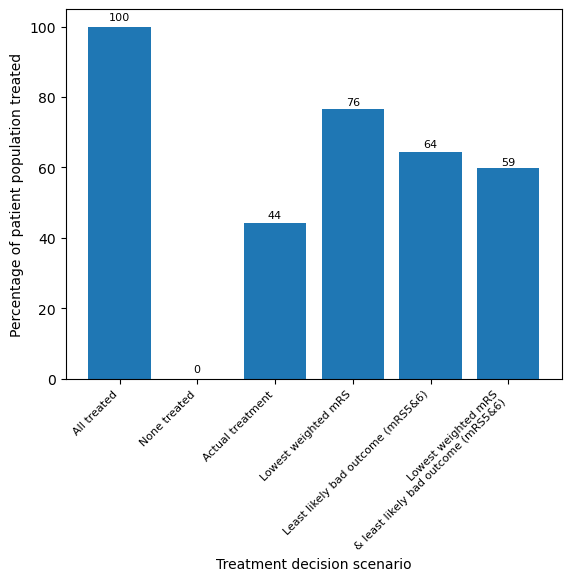

In [42]:
plot_bar(xticks, df_treatment_decision_per_scenario[columns].mean()*100);

Save results to file

In [43]:
# Model filename
filename = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + 
                 '_scenario_treatment_decision_results.csv'))

df_treatment_decision_per_scenario.to_csv(filename)

### Store results: weighted mRS probability from their treatment decision
Initialise dataframe to store each patients weighted mRS score based on the treatment they got in each scenario 

In [44]:
df_weighted_mrs_per_scenario = pd.DataFrame()

df_weighted_mrs_per_scenario["All_treated"] = weighted_mrs_all_treated
df_weighted_mrs_per_scenario["None_treated"] = weighted_mrs_none_treated
df_weighted_mrs_per_scenario["Actual_treatment"] = weighted_mrs_actual_treatment
df_weighted_mrs_per_scenario["Lowest_weighted_mrs"] = weighted_mrs_lowest_weighted_mrs
df_weighted_mrs_per_scenario["Least_mrs5_6"] = weighted_mrs_least_mrs5_6
df_weighted_mrs_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"] = weighted_mrs_lowest_weighted_mrs_and_least_mrs5_6

df_weighted_mrs_per_scenario.set_index(mask_all_treated.index, inplace=True)

Show the overview of this result, per scenario

In [45]:
df_weighted_mrs_per_scenario.describe()

,All_treated,None_treated,Actual_treatment,Lowest_weighted_mrs,Least_mrs5_6,Lowest_weighted_mrs_and_least_mrs5_6
count,15680.000000,15680.000000,15680.000000,15680.000000,15680.000000,15680.000000
mean,2.559482,2.768774,2.627625,2.528256,2.552677,2.548054
std,1.359519,1.431196,1.394960,1.361934,1.354470,1.355344
min,0.167492,0.182136,0.182136,0.167492,0.167492,0.167492
25%,1.444985,1.563107,1.479651,1.408437,1.443417,1.435826
50%,2.214963,2.438452,2.282206,2.180482,2.215758,2.211186
75%,3.551599,3.941276,3.667739,3.532568,3.544340,3.543315
max,5.942042,5.940568,5.940568,5.940568,5.940568,5.940568


Create violin plot (range of weighted mRS scores for the population per treatment decision scenario)

In [46]:
def create_violin_plot(violin_data, xticks, y_label, ax=None, title=""):
    ax = ax or plt.gca()
    
    ax.violinplot(violin_data, showextrema=False, showmeans=True, widths=0.9)

    # customise the axes
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(columns) + 1))
    ax.set_xticklabels(xticks, rotation=45, fontsize=8, ha='right')

    ax.set_xlim(0.25, len(columns) + 0.75)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Treatment decision scenario', fontsize=12)
    ax.set_title(title, fontsize=12)

    return(ax)

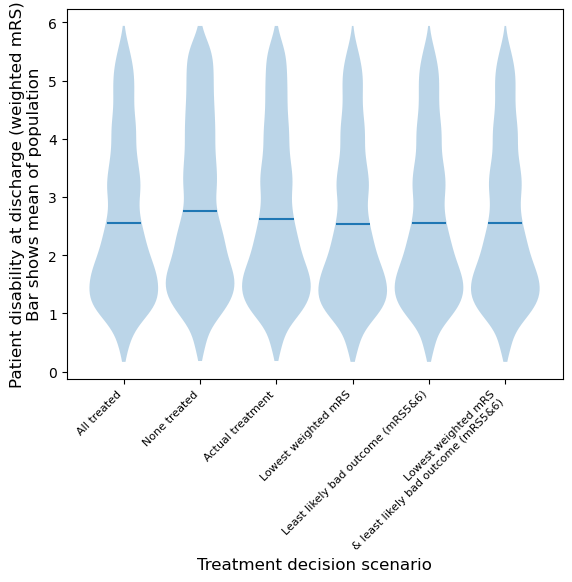

In [47]:
create_violin_plot(df_weighted_mrs_per_scenario[columns], xticks, 
        ('Patient disability at discharge (weighted mRS)\n'
        'Bar shows mean of population'));

Save results to file

In [48]:
# Model filename
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_scenario_weighted_mrs_results.csv'))

df_weighted_mrs_per_scenario.to_csv(filename)

Number of patients for who treatment did not change their weighted mRS

In [49]:
mask_weighted_mrs_indifferent_outcome.sum()

0

Number of patients for who treatment not change their likelihood being mRS0-4

In [50]:
mask_weighted_mrs_indifferent_proportion.sum()

0

# Questions to ask of the data

## Question 1. Is it largely an effect of stroke severity?

Would be expect to see a bigger shift in patient outcome with the more severe strokes?

Most of the strokes are mild severity. Expect that they will be receiving the least effect from thrombolysis treatment. This will weight the population outcome to appear as a smaller effect.

If look at subgroups of patients (say, moderate strokes, or severe stroke with no prior disability) we may see a larger effect.

Look at results for subgroups of patients

### 1. Subgroup: Patients with mild stroke

In [51]:
mask_mild = data["stroke_severity"] < 5

df_treatment_per_scenario_mild_stroke = (
    df_treatment_decision_per_scenario[mask_mild])

df_weighted_mrs_per_scenario_mild_stroke = (
            df_weighted_mrs_per_scenario[mask_mild])

### 2. Subgroup: Patients with moderate stroke

In [52]:
mask_moderate = (data["stroke_severity"] > 4) & (data["stroke_severity"] < 21)

df_treatment_per_scenario_moderate_stroke = (
    df_treatment_decision_per_scenario[mask_moderate])

df_weighted_mrs_per_scenario_moderate_stroke = (
    df_weighted_mrs_per_scenario[mask_moderate])

### 3. Subgroup: Patients with severe stroke

In [53]:
mask_severe = data["stroke_severity"] > 20

df_treatment_per_scenario_severe_stroke = (
    df_treatment_decision_per_scenario[mask_severe])

df_weighted_mrs_per_scenario_severe_stroke = (
    df_weighted_mrs_per_scenario[mask_severe])

### 4. Subgroup: Patients with severe stroke with no prior disability

In [54]:
mask_severe = data["stroke_severity"] > 20
mask_no_prior_disability = data["prior_disability"] <2
mask = mask_severe * mask_no_prior_disability

df_treatment_per_scenario_severe_stroke_no_prior_disability = (
    df_treatment_decision_per_scenario[mask])

df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability = (
    df_weighted_mrs_per_scenario[mask])


### 5. Subgroup: Patients with not a mild stroke (NIHSS 5+)

In [55]:
mask_not_mild = data["stroke_severity"] >= 5

df_treatment_per_scenario_not_mild_stroke = (
    df_treatment_decision_per_scenario[mask_not_mild])

df_weighted_mrs_per_scenario_not_mild_stroke = (
            df_weighted_mrs_per_scenario[mask_not_mild])

Show each of these patient subgroups in their own bar plot

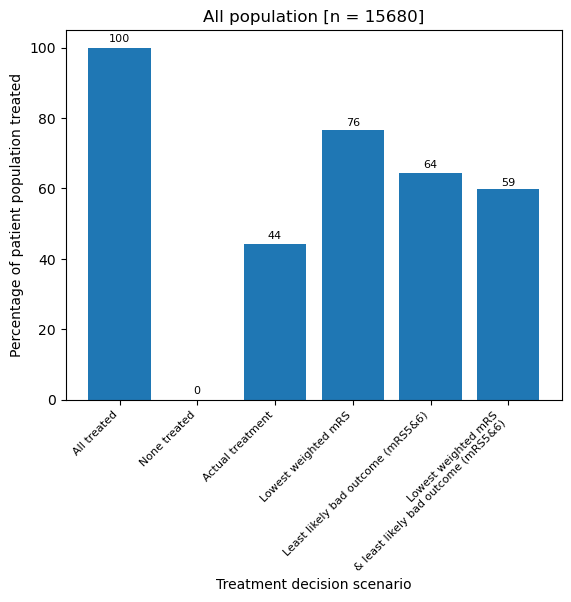

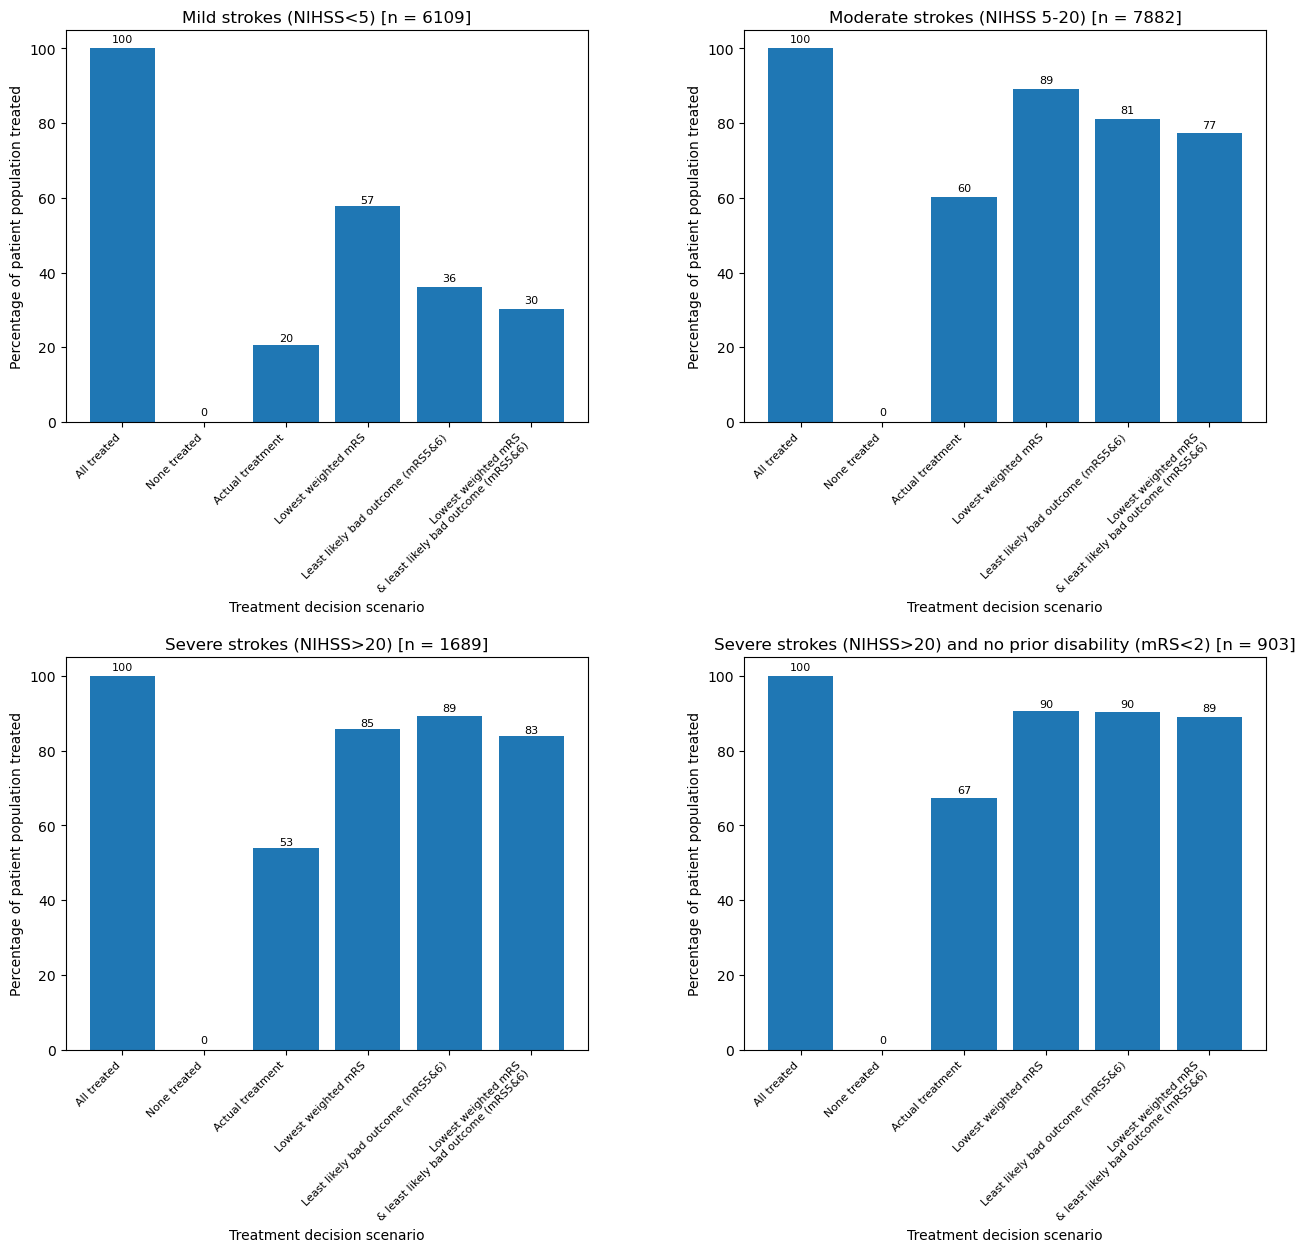

In [56]:
n_patients = df_treatment_decision_per_scenario.shape[0]
title = f"All population [n = {n_patients}]"
plot_bar(xticks, df_treatment_decision_per_scenario[columns].mean()*100, title=title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

n_patients = df_treatment_per_scenario_mild_stroke.shape[0]
title = f"Mild strokes (NIHSS<5) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_mild_stroke[columns].mean()*100, ax1, title=title)

n_patients = df_treatment_per_scenario_moderate_stroke.shape[0]
title = f"Moderate strokes (NIHSS 5-20) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_moderate_stroke[columns].mean()*100, ax2, title=title)

n_patients = df_treatment_per_scenario_severe_stroke.shape[0]
title = f"Severe strokes (NIHSS>20) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_severe_stroke[columns].mean()*100, ax3, title=title)

n_patients = df_treatment_per_scenario_severe_stroke_no_prior_disability.shape[0]
title = f"Severe strokes (NIHSS>20) and no prior disability (mRS<2) [n = {n_patients}]"
plot_bar(xticks, df_treatment_per_scenario_severe_stroke_no_prior_disability[columns].mean()*100, ax4, title=title)

fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=0.95, wspace=0.3, hspace=0.6)
plt.show()

Show each of these patient subgroups in their own violin plot

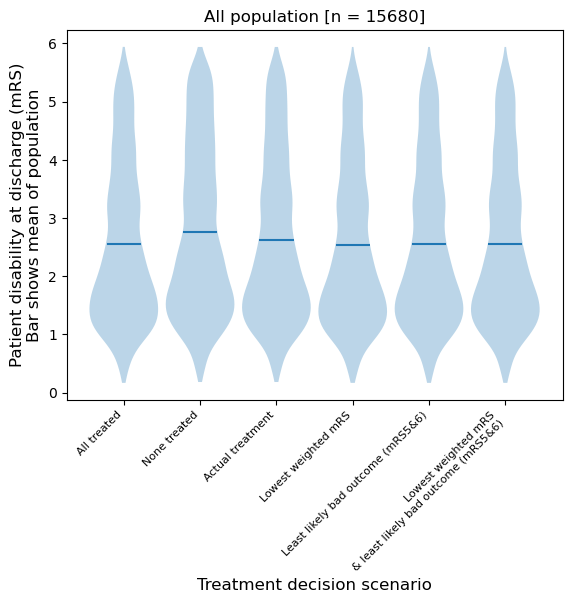

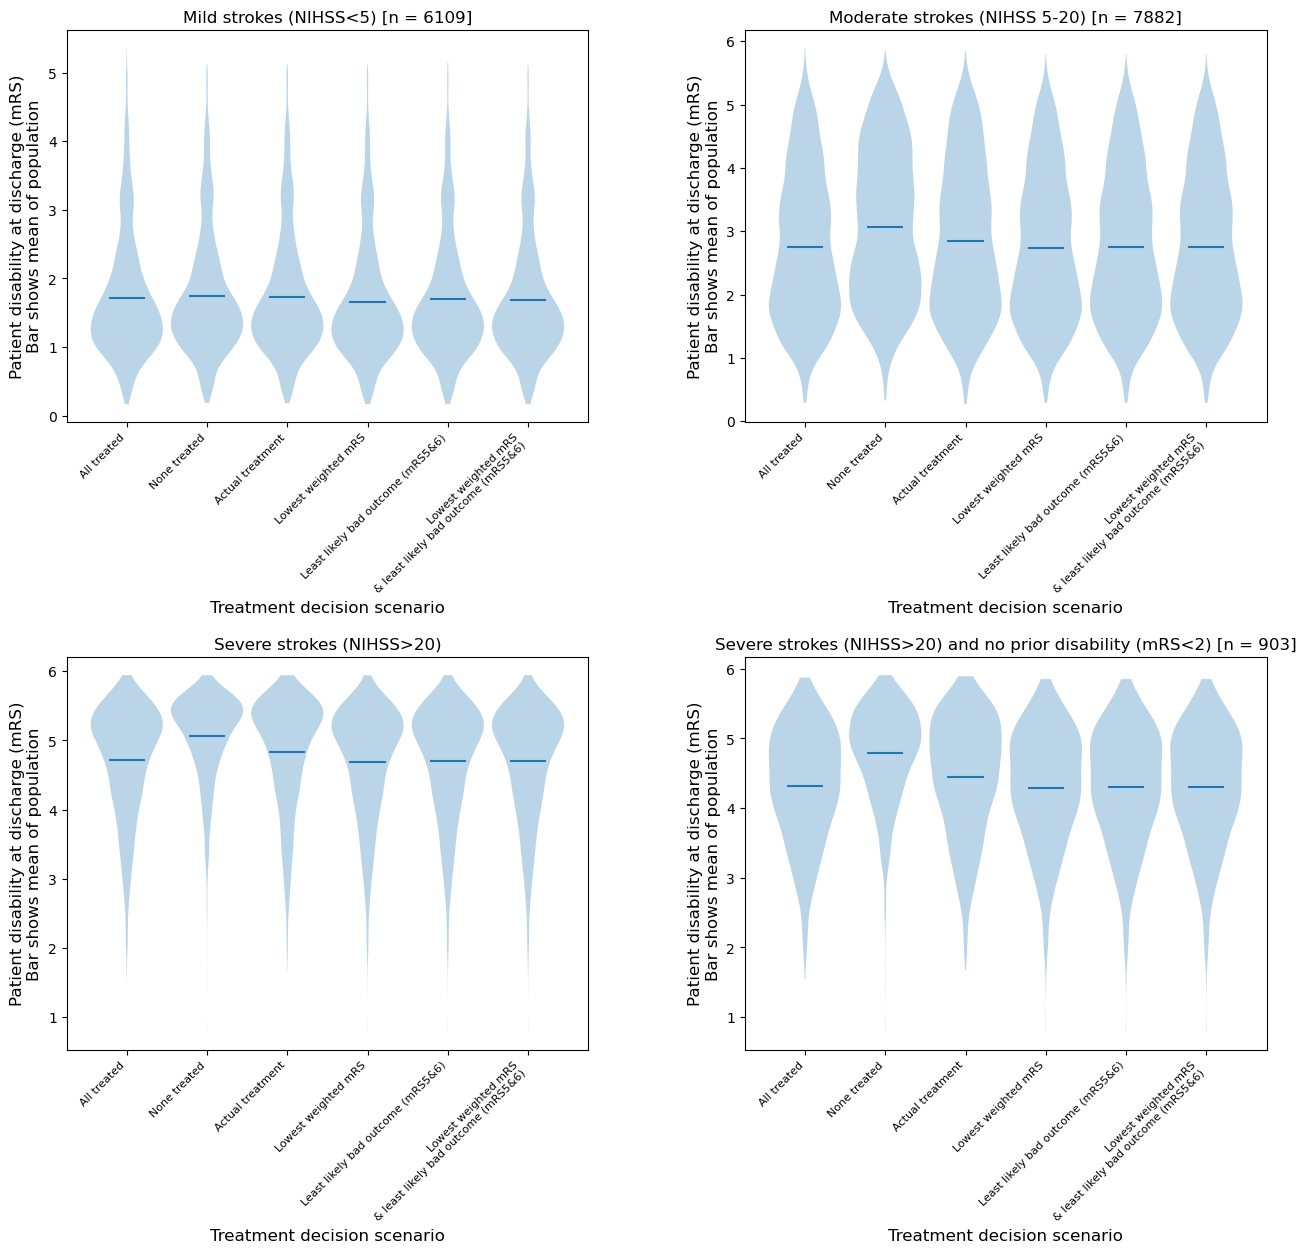

In [57]:
n_patients = df_weighted_mrs_per_scenario.shape[0]
title = f"All population [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        title=title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

n_patients = df_weighted_mrs_per_scenario_mild_stroke.shape[0]
title = f"Mild strokes (NIHSS<5) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_mild_stroke[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax1, title=title)

n_patients = df_weighted_mrs_per_scenario_moderate_stroke.shape[0]
title = f"Moderate strokes (NIHSS 5-20) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_moderate_stroke[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax2, title=title)

n_patients = df_weighted_mrs_per_scenario_severe_stroke.shape[0]
title = f"Severe strokes (NIHSS>20) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_severe_stroke[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax3, title="Severe strokes (NIHSS>20)")

n_patients = df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability.shape[0]
title = f"Severe strokes (NIHSS>20) and no prior disability (mRS<2) [n = {n_patients}]"
create_violin_plot(df_weighted_mrs_per_scenario_severe_stroke_no_prior_disability[columns], xticks, 
        'Patient disability at discharge (mRS)\nBar shows mean of population', 
        ax4, title=title)

fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=0.95, wspace=0.3, hspace=0.6)
plt.show()

## Question 2: Is there a bigger effect of treatment for patients with a worse predicted outcome without treatment

For each patient calculate the benefit they receive due to treatment ("Difference in weighted mRS when have treatment"). A negative value represents a reduction in mRS due to treatment - this is an improvement.

Plot this against "Weighted mRS without treatment".

If there is a larger treatment benefit for those with a higher mRS without treatment, the relationship will show the patients with a larger "Weighted mRS without treatment", will have a lower (more negative) "Difference in weighted mRS when have treatment".

Look at this for all the patients, and per subgroups based on their prior disability level.

In [58]:
def fit_logstic_regression(x, y):
    # Get r-square of predicted thrombolysis rate.
    slr = LinearRegression()
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    return(slr, r_square)

In [59]:
def plot_scatter(x, y, slr, r_square, ax, x_min, x_max, y_min, y_max, xlabel, 
                 ylabel, title):
    
    ax.scatter(x, y, s=0.2, c="k", alpha=0.3)

    plt.plot (x, slr.predict(x), color = 'grey', linewidth=0.8, linestyle="--")
    
    x_range = x_max - x_min
    text = f'R squared: {r_square:.3f}'
    ax.text((x_min + x_range/20), y_min*0.9, text, 
             bbox=dict(facecolor='white', edgecolor='white'))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"For patients with prior disability mRS: {title}")
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)

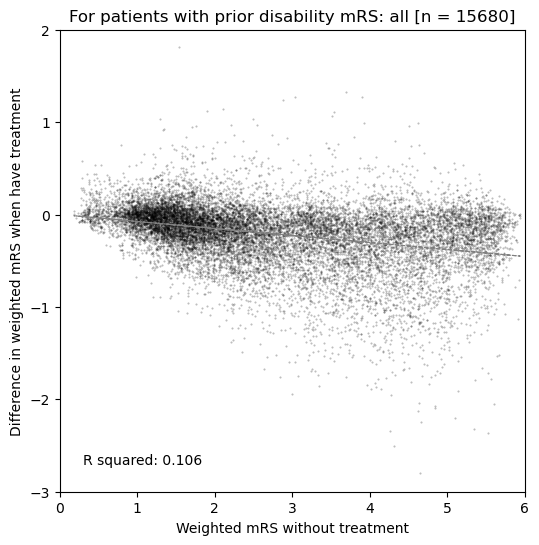

In [60]:
x = weighted_mrs_none_treated.reshape(-1, 1)

predicted_mrs_shift_due_to_thrombolysis = (
                        weighted_mrs_all_treated - weighted_mrs_none_treated)
y = predicted_mrs_shift_due_to_thrombolysis.reshape(-1, 1)

x_min = round(x.min(),0)
x_max = round(x.max(),0)
y_min = round(y.min(),0)
y_max = round(y.max(),0)

# The full dataset
(slr, r_square) = fit_logstic_regression(x, y)

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

n_patients = x.shape[0]
title = f"all [n = {n_patients}]"
plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
             "Weighted mRS without treatment", 
             "Difference in weighted mRS when have treatment", title)

Per prior disabiliy

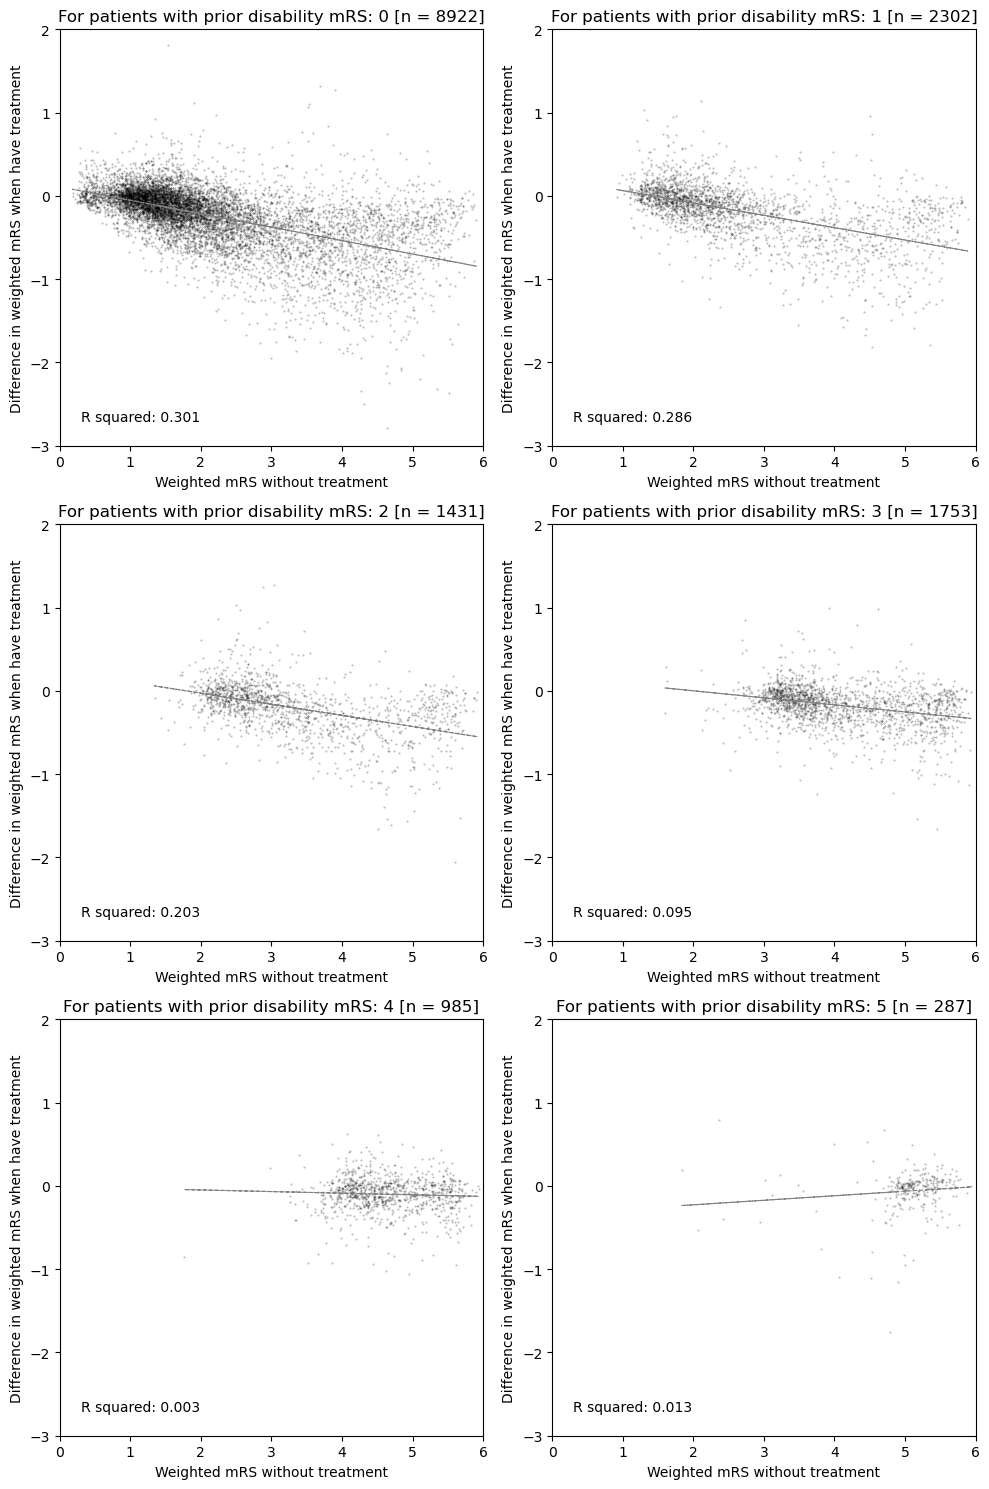

In [61]:
fig = plt.figure(figsize=(10,15))

for subplot, prior_disability in enumerate(list(set(data["prior_disability"]))):
    mask = data["prior_disability"] == prior_disability
    x = weighted_mrs_none_treated[mask].reshape(-1, 1)
    y = predicted_mrs_shift_due_to_thrombolysis[mask].reshape(-1, 1)

    # The full dataset
    (slr, r_square) = fit_logstic_regression(x, y)

    ax1 = fig.add_subplot(3,2,subplot+1)

    n_patients = x.shape[0]
    title = f"{prior_disability} [n = {n_patients}]"
    plot_scatter(x, y, slr, r_square, ax1, x_min, x_max, y_min, y_max, 
                 "Weighted mRS without treatment", 
                 "Difference in weighted mRS when have treatment", 
                 title)
    
fig.tight_layout()

## Question 3: Which type of patients have indifferent outcomes with treatment?

Where's the break even point?

In [62]:
patient_in_both = (
    mask_weighted_mrs_indifferent_outcome == mask_weighted_mrs_indifferent_proportion)
percent_matched = (patient_in_both.sum()/mask_weighted_mrs_indifferent_outcome.shape[0] * 100)
print(f"Of the patients that have an indifferent weighted mRS proportion due to treatment"
      f", {round(percent_matched)}% of them also have an indifferent outcome")

Of the patients that have an indifferent weighted mRS proportion due to treatment, 100% of them also have an indifferent outcome


As they are the same patient subgroup, the followig results are for the same patient subgroup.

Describe the patient characteristics that have indifferent outcome based on treatment

In [63]:
data[mask_weighted_mrs_indifferent_outcome].describe()

,prior_disability,stroke_severity,age,onset_to_thrombolysis_time,any_afib_diagnosis,precise_onset_known,arrival_to_scan_time,onset_to_arrival_time,onset_during_sleep,discharge_disability,...,team_108,team_109,team_110,team_111,team_112,team_113,team_114,team_116,team_117,team_118
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data[mask_weighted_mrs_indifferent_proportion].describe()

,prior_disability,stroke_severity,age,onset_to_thrombolysis_time,any_afib_diagnosis,precise_onset_known,arrival_to_scan_time,onset_to_arrival_time,onset_during_sleep,discharge_disability,...,team_108,team_109,team_110,team_111,team_112,team_113,team_114,team_116,team_117,team_118
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Are there patients that the high benchmarks are giving thrombolysis to, that they shouldn’t (causing harm)?

What are the differences in patients between benchmark choice and best outcomes? Are the benchmark hosptials making the best decisions?

Not going to have a scenario for the benchmark set of hospitals based on best outcomes, because if we are interested in best decisions then we can get better decisions by the algortihm (it has learnt more patterns than individual hospitals).
        

Include this analysis in the WebApp - provide more than 1 treatment scenario. If you want to be conservative use the scenario that requires a threshold for the improvement (without increasing bad outcome) "IMPROVES WEIGHTED AVE mRS BY 0.2 & BEST LIKELIHOOD mRS0-4". If want to be less conservative use "BEST WEIGHTED mRS & BEST LIKELIHOOD mRS0-4" which shows any improvement (without increasing bad outcome). Neither of these scnarios increase the risk of causing harm.

This approach moves away from "computer says this", it instead gives 2 options that is beneficial, but the clincian chooses their level of improvement.

Which patients do benchmark decide to give IVT, and the "BEST WEIGHTED mRS & BEST LIKELIHOOD mRS0-4" says no.

Are there any patterns for the patients where "BEST WEIGHTED mRS & BEST LIKELIHOOD mRS0-4" says yes, and benchmark say no. And vice versa?

Could we use cluster analysis to look at this?

Or the Radar/spider diagrams?

Could give patients that the benchmark hospitals choose to give Ivt, but the "Best Outcome" decision says no: Store as a new label.
Then build a model to predict the new label, calculate SHAP for it. Then can analyse which are the feature values that mostly predict a patient the benchmark treats, but outcome wise you shouldn’t.

The 2 best outcome scenarios bracket the benchmark rate (45 to 60, vs 49%).

Create a Venn diagram between patients the benchmark treat, and the 2 best outcome scenarios treat.

In [65]:
df_treatment_decision_per_scenario.head()

,All_treated,None_treated,Actual_treatment,Lowest_weighted_mrs,Least_mrs5_6,Lowest_weighted_mrs_and_least_mrs5_6
0,1,0,1,1,1,1
1,1,0,0,0,0,0
2,1,0,0,1,1,1
3,1,0,0,0,0,0
4,1,0,0,1,1,1


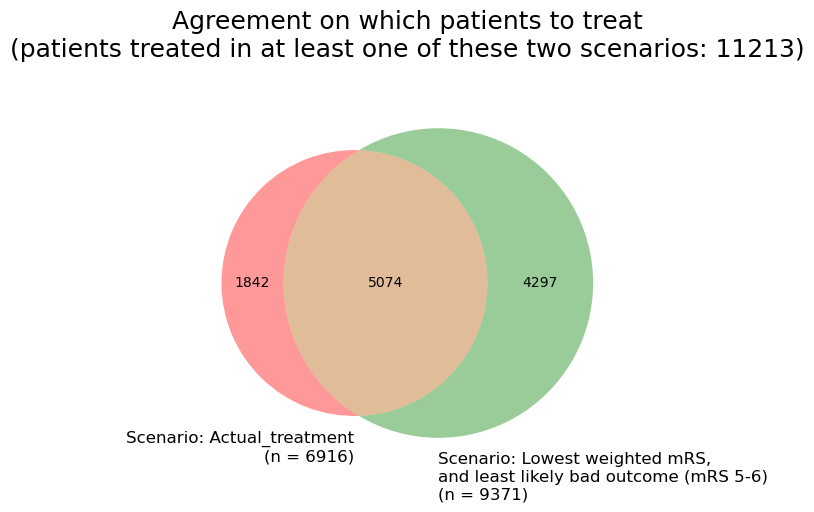

In [66]:
venn_diagram_columns = ["Actual_treatment",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Actual_treatment" , 
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS 5-6)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
list_vd_sets = []
labels =[]
count = 0
for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
    mask = df_treatment_decision_per_scenario[col]==1
    list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
    count_ivt = int(df_treatment_decision_per_scenario[col].sum())
    labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")
    count+=1
# Create venn diagram
venn2(list_vd_sets, labels);

# Calculate the number of patients treated across any scenario
mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
n_patients_treated = mask.sum()

# Add title
plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
          f" one of these two scenarios: {n_patients_treated})", 
          fontsize=18, pad=30)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_venn_diagram_2features.jpg'))

plt.savefig(filename, dpi=300)


In [67]:
def create_donuts(df_treatment_decision_per_scenario, loop=0):
    
    n_population = df_treatment_decision_per_scenario.shape[0]

    TN_actual = ((df_treatment_decision_per_scenario["Actual_treatment"]==0) * 
                (df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0)).sum()
    FN_actual = ((df_treatment_decision_per_scenario["Actual_treatment"]==0) * 
                (df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1)).sum()
    FP_actual = ((df_treatment_decision_per_scenario["Actual_treatment"]==1) * 
                (df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0)).sum()
    TP_actual = ((df_treatment_decision_per_scenario["Actual_treatment"]==1) * 
                (df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1)).sum()

    actual_pie = np.array([TN_actual, FN_actual, FP_actual, TP_actual])

    mylabels_actual = [f"True negative: {round(TN_actual/n_population*100,1)}%", 
                       f"False negative: {round(FN_actual/n_population*100,1)}%", 
                       f"False positive: {round(FP_actual/n_population*100,1)}%", 
                       f"True positive: {round(TP_actual/n_population*100,1)}%"]
    mycolors = ["blue", "orange", "green", "red"]

    fig = plt.figure(figsize=(5,5))

    ax1 = fig.add_subplot(111)
    ax1.pie(actual_pie, labels=mylabels_actual, colors=mycolors, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
    ax1.set_title("Actual treatment vs best outcome")
    my_circle = plt.Circle( (0,0), 0.4, color='white')
    ax1.add_artist(my_circle)

    plt.tight_layout()


    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_loop_' + str(loop) + 
                             '_donuts.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show() 

    actual_pie_pc = actual_pie/n_population*100

    return(actual_pie_pc)

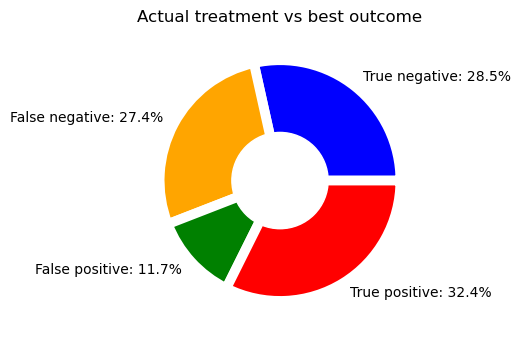

In [68]:
(actual_tn_fn_fp_tp) = create_donuts(df_treatment_decision_per_scenario)

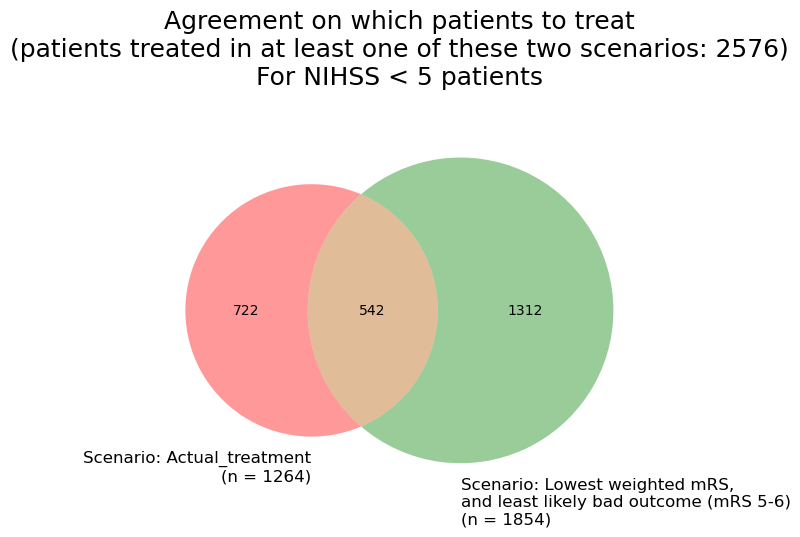

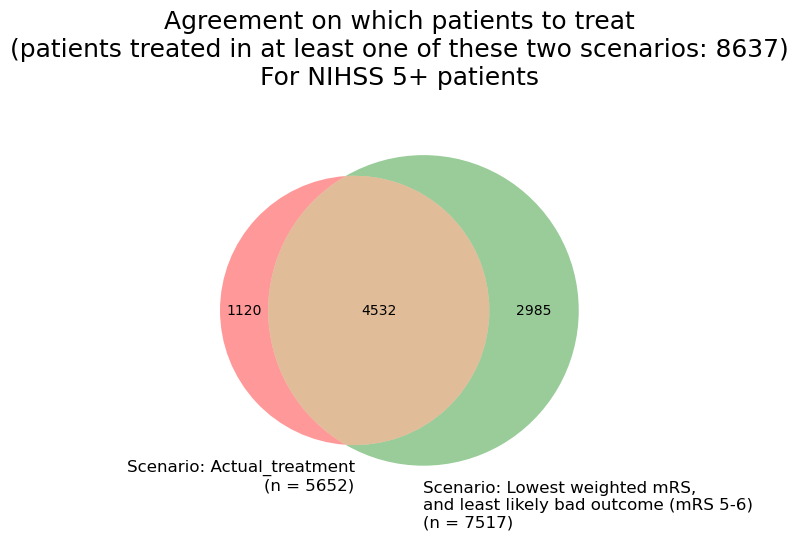

In [69]:
# split by stroke severity: NIHSS <5, NIHSS 5+

venn_diagram_columns = ["Actual_treatment",
                        "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Actual_treatment" , 
                       "Lowest weighted mRS,\nand least likely bad outcome (mRS 5-6)"]

# Put data in required format for venn diagram.
# A list of sets
# Each set contains the patient index numbers that recieve IVT in that scenario
subgroups = [df_treatment_per_scenario_mild_stroke,
             df_treatment_per_scenario_not_mild_stroke]

subgroup_labels = ["NIHSS < 5", "NIHSS 5+"]

for (subgroup, sg_label) in zip(subgroups, subgroup_labels):

    list_vd_sets = []
    labels =[]
    for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
        mask = subgroup[col]==1
        list_vd_sets.append(set(subgroup[mask].index))
        count_ivt = int(subgroup[col].sum())
        labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

    # Create venn diagram
    venn2(list_vd_sets, labels);

    # Calculate the number of patients treated across any scenario
    mask = subgroup[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated = mask.sum()

    # Add title
    plt.title(f"Agreement on which patients to treat\n(patients treated in at least"
            f" one of these two scenarios: {n_patients_treated})"
            f"\nFor {sg_label} patients", 
            fontsize=18, pad=30)

#    filename = os.path.join(paths.image_save_path, 
#                            (paths.notebook + paths.model_text + 
#                        '_venn_diagram_2features.jpg'))

#    plt.savefig(filename, dpi=300)

    plt.show()




We have defined two scenarios that decide to treat based on the best outcome for the patient. Both do not increase the risk of a bad outcome with treatment (does not increase the likelihood of being mRS 5 and mRS 6). One only gives treatment if the weighted average mRS is improved, and the other is if the improvement is beyond a set threshold (we are using 0.2).

We compare the choice of whether to give thrombolysis to each of the 91394 patients, based on the benchmark decision, the more cautious best outcome, and the less cautious best outcome.

55260 patients are treated by the less cautious scenario.
41699 patients are treated by the more cautious scenario.
24469 patients are treated by the benchmark decision.

Of the 24469 patients are treated by the benchmark decision, 11382 are also treated in both of the best outcome scenarios, 3650 are also treated in the less caution scenario, and 9437 patients are not treated in either best outcome scenarios.

Can we unpick any patient characteristics where benchmark hospitals treat but the outcome scenarios do not?

Also can we unpick any patient characteristics where benchmark hospitals do not treat, but the outcome scenarios do?


For each feature create a set of four histograms:
1. of all the 64697 patients treated in either scenario
1. for the 9437 patients that only the benchmark treat
1. for the 15032 patients that both treat
1. for the 40228 patients that only the best outcome treat

In [70]:
def venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                                 scenarios_short_name, scenarios_full_name, 
                                 feat, df_treatment_decision_per_scenario, 
                                 scenarios_abrev_name, data_for_histogram, 
                                 title="", labels=""):

    
    fig3 = plt.figure(constrained_layout=True, figsize=(10,10))

    gs = fig3.add_gridspec(5, 3, hspace=0.2)

    f3_ax1 = fig3.add_subplot(gs[1:4, :3])
    f3_ax2 = fig3.add_subplot(gs[4,0])
    f3_ax2.set_title('gs[1, :-1]')
    f3_ax3 = fig3.add_subplot(gs[4,1])
    f3_ax3.set_title('gs[1:, -1]')
    f3_ax4 = fig3.add_subplot(gs[4,2])
    f3_ax4.set_title('gs[-1, 0]')
    f3_ax5 = fig3.add_subplot(gs[0,1])
    f3_ax5.set_title('gs[-1, 0]')

    if len(title)==0:
        title = (f"Which patients receive thombolysis?\nComparing scenarios: "
                 f"'{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'")

    fig3.suptitle(title, fontsize=20)

    subplots = [f3_ax2, f3_ax3, f3_ax4, f3_ax5]



    # DEFINE ALL THE MASKS

    # mask of the patients treated in bm
    s1_mask = df_treatment_decision_per_scenario[scenario_columns[0]] == 1

    # mask of the patients treated across any scenario
    either_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0

    # mask of the patients treated in outcome
    s2_mask = df_treatment_decision_per_scenario[scenario_columns[1]] == 1

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2

    # Masks in plot order
    mask_patients = [s1_only_mask, both_mask, s2_only_mask, either_mask]

    # Labels in plot order
    if len(labels)==0:
        labels = [f"Patients that receive thrombolysis\nin '{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
                f"Patients that receive thrombolysis\nin both scenarios (n = {int(both_mask.sum())})",
                f"Patients that receive thrombolysis\nin '{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})", 
                f"Patients that receive thrombolysis\nin either scenario (n = {int(either_mask.sum())})"]


    # PLOT1 Plot the venn diagram

    # Put data in required format for venn diagram.
    # A list of sets
    # Each set contains the patient index numbers that recieve IVT in that scenario
    list_vd_sets = []
    list_vd_labels =[]
    for col, label in zip (scenario_columns, venn_diagram_xticks):
        mask = df_treatment_decision_per_scenario[col]==1
        list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
        count_ivt = int(df_treatment_decision_per_scenario[col].sum())
        list_vd_labels.append("Scenario: " + label +  f"\n(n = {count_ivt})")

    # Create venn diagram
    v = venn2(list_vd_sets, list_vd_labels, ax=f3_ax1);

    #f3_ax1.set_title(f"Who gets treated?", fontsize=14)

    # Calculate the number of patients treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated = mask.sum()

    # PLOTS 2-5 histograms

    # For each set of patients (all, bm, both, outcome)
    for (mask, label, subplot) in zip(mask_patients, labels, subplots):
        if feat == "onset_to_thrombolysis_time":
            counts, bins = np.histogram(data_for_histogram[feat][mask])
            subplot.hist(bins[:-1], bins, weights=counts)
        else:
            x = data_for_histogram[mask.values].groupby([feat]).count().index
            y = data_for_histogram[mask.values].groupby([feat]).count().iloc[:,0].values
            subplot.bar(x,y)

        if feat == "stroke_team":
            subplot.set_xticklabels([]);
        subplot.set_title(label, fontsize=10)

        if data_for_histogram[feat].nunique() == 2:
            subplot.set_xticks([0,1])

        subplot.set_xlabel(feat)
        subplot.set_ylabel("Count")
        subplot.set_xlim(0,data_for_histogram[feat].max())

    plt.subplots_adjust(top=0.1)

    filename_suffix = f"{feat}_{scenarios_abrev_name[0]}_vs_{scenarios_abrev_name[1]}"

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            f'_venn_with_hists_{filename_suffix}.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

In [71]:
mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==0
mask_not_actual_but_best = mask1 * mask2

mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==1
mask_actual_but_not_best = mask1 * mask2

mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==1
mask_actual_and_best = mask1 * mask2

mask1 = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0
mask2 = df_treatment_decision_per_scenario["Actual_treatment"]==0
mask_not_actual_and_not_best = mask1 * mask2

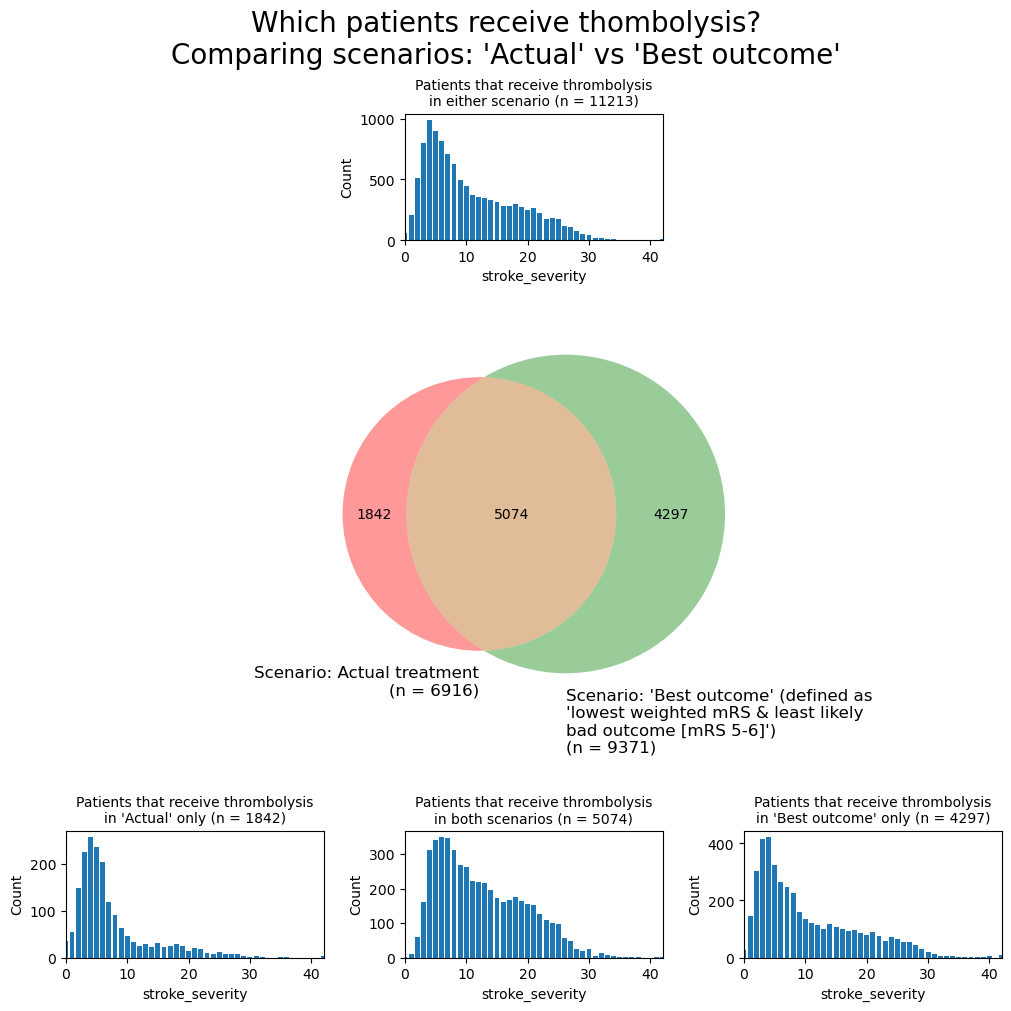

In [72]:
# Observed vs best outcome

scenario_columns = ["Actual_treatment",
                    "Lowest_weighted_mrs_and_least_mrs5_6"]

venn_diagram_xticks = ["Actual treatment", 
                    "'Best outcome' (defined as\n'lowest weighted mRS & least likely\nbad outcome [mRS 5-6]')"]

scenarios_abrev_name = ["Actual", "Best"]
scenarios_short_name = ["Actual", "Best outcome"]
scenarios_full_name = ["Actual treatment", 
                       "Lowest weighted mRS and least likely bad outcome (mRS 5-6)"]

feat = "stroke_severity"

venn_diagram_with_histograms(scenario_columns, venn_diagram_xticks, 
                             scenarios_short_name, scenarios_full_name, 
                             feat, df_treatment_decision_per_scenario, 
                             scenarios_abrev_name, data_for_histogram)

For the patients that actual gave thrombolysis when the model predicted the treatment would not give tem the best outcome, how much worse were their outcome?

Calculate the net change in benefit due to treatment (for each part of the benefit criteria)

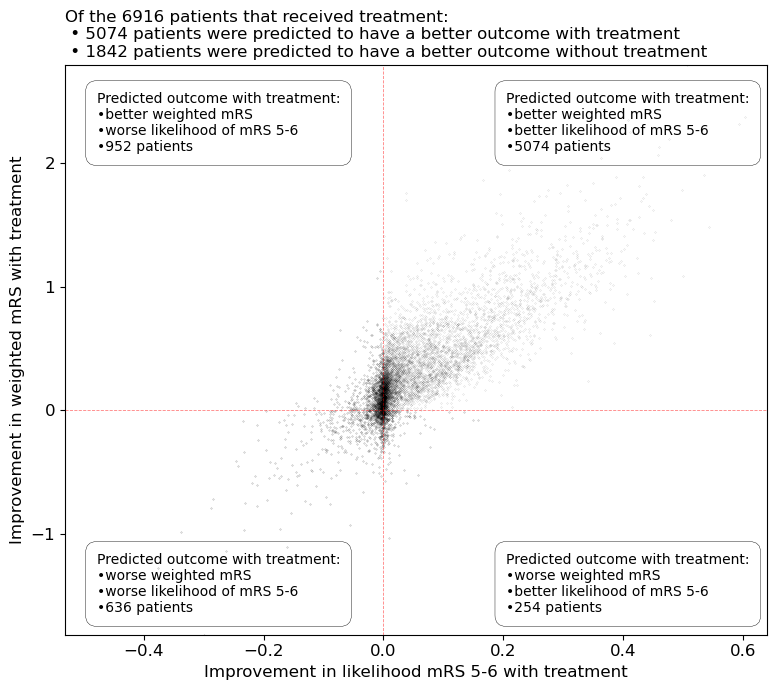

In [73]:
x_min = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).max())
x_max = -((proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated).min())
y_min = -((weighted_mrs_all_treated - weighted_mrs_none_treated).max())
y_max = -((weighted_mrs_all_treated - weighted_mrs_none_treated).min())

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.set_title(f"Of the "
             f"{mask_actual_and_best.sum() + mask_actual_but_not_best.sum()}"
             f" patients that received "
             f"treatment:\n \u2022 {mask_actual_and_best.sum()} patients were"
             f" predicted to have a better outcome with treatment\n \u2022 "
             f"{mask_actual_but_not_best.sum()} patients were predicted to have"
             f" a better outcome without treatment",
             fontsize=12, loc="left")

net_change_mrs5_6_actual_but_not_best = (
                proportion_mrs5_6_all_treated[mask_actual_but_not_best] - 
                proportion_mrs5_6_not_treated[mask_actual_but_not_best])

net_change_weighted_mrs_actual_but_not_best = (
                weighted_mrs_all_treated[mask_actual_but_not_best] -
                weighted_mrs_none_treated[mask_actual_but_not_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
ax.scatter(-net_change_mrs5_6_actual_but_not_best, 
           -net_change_weighted_mrs_actual_but_not_best,
            s=0.05,  alpha=0.5,  color="k")


net_change_mrs5_6_actual_and_best = (
                proportion_mrs5_6_all_treated[mask_actual_and_best] - 
                proportion_mrs5_6_not_treated[mask_actual_and_best])

net_change_weighted_mrs_actual_and_best = (
                weighted_mrs_all_treated[mask_actual_and_best] -
                weighted_mrs_none_treated[mask_actual_and_best])

# plot the negative so as to plot the improvement, and not the net change (where a negative is the improvement)
ax.scatter(-net_change_mrs5_6_actual_and_best, 
           -net_change_weighted_mrs_actual_and_best, 
           s=0.01,  alpha=0.5,  color="k")

#y_min = min(-net_change_weighted_mrs_actual_but_not_best.max(), -net_change_weighted_mrs_actual_and_best.max())
#y_max = max(-net_change_weighted_mrs_actual_but_not_best.min(), -net_change_weighted_mrs_actual_and_best.min())
#x_min = min(-net_change_mrs5_6_actual_but_not_best.max(), -net_change_mrs5_6_actual_and_best.max())
#x_max = max(-net_change_mrs5_6_actual_but_not_best.min(), -net_change_mrs5_6_actual_and_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, 
        alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, 
        alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best > 0
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.9, y_min*0.9, 
        (f"Predicted outcome with treatment:\n\u2022worse weighted mRS\n"
         f"\u2022worse likelihood of mRS 5-6\n\u2022{mask.sum()} patients"), 
        fontsize=10, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                  boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_actual_but_not_best > 0 
mask2 = net_change_weighted_mrs_actual_but_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.9, y_max*0.75, 
        (f"Predicted outcome with treatment:\n\u2022better weighted mRS\n"
         f"\u2022worse likelihood of mRS 5-6\n\u2022{mask.sum()} patients"), 
         fontsize=10, color='k', 
         bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                   boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_actual_but_not_best < 0 
mask2 = net_change_weighted_mrs_actual_but_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.32, y_min*0.9, 
        (f"Predicted outcome with treatment:\n\u2022worse weighted mRS\n"
         f"\u2022better likelihood of mRS 5-6\n\u2022{mask.sum()} patients"), 
         fontsize=10, color='k', 
         bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                   boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.32, y_max*0.75, 
        (f"Predicted outcome with treatment:\n\u2022better weighted mRS\n"
         f"\u2022better likelihood of mRS 5-6\n"
         f"\u2022{mask_actual_and_best.sum()} patients"), 
        fontsize=10, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                  boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS 5-6 with treatment", fontsize=12)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_scatter_criteria_treated.jpg'))

plt.savefig(filename, dpi=300)


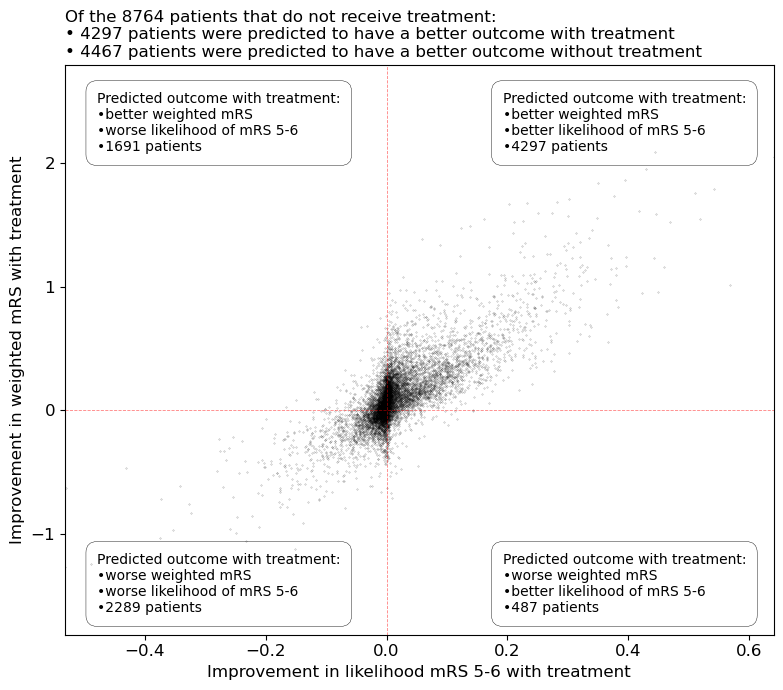

In [76]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.set_title(f"Of the "
             f"{mask_not_actual_but_best.sum() + mask_not_actual_and_not_best.sum()}"
             f" patients that do not receive treatment:\n"
             f"\u2022 {mask_not_actual_but_best.sum()} patients were predicted"
             f" to have a better outcome with treatment\n"
             f"\u2022 {mask_not_actual_and_not_best.sum()} "
             f"patients were predicted to have a better outcome without "
             f"treatment",
             fontsize=12, loc='left')

net_change_mrs5_6_not_actual_and_not_best = (
                proportion_mrs5_6_all_treated[mask_not_actual_and_not_best] - 
                proportion_mrs5_6_not_treated[mask_not_actual_and_not_best])

net_change_weighted_mrs_not_actual_and_not_best = (
                weighted_mrs_all_treated[mask_not_actual_and_not_best] -
                weighted_mrs_none_treated[mask_not_actual_and_not_best])

ax.scatter(-net_change_mrs5_6_not_actual_and_not_best, 
           -net_change_weighted_mrs_not_actual_and_not_best,
            s=0.05,  alpha=0.5,  color="k")


net_change_mrs5_6_not_actual_but_best = (
                proportion_mrs5_6_all_treated[mask_not_actual_but_best] - 
                proportion_mrs5_6_not_treated[mask_not_actual_but_best])

net_change_weighted_mrs_not_actual_but_best = (
                weighted_mrs_all_treated[mask_not_actual_but_best] -
                weighted_mrs_none_treated[mask_not_actual_but_best])

ax.scatter(-net_change_mrs5_6_not_actual_but_best, 
           -net_change_weighted_mrs_not_actual_but_best, 
           s=0.05,  alpha=0.5,  color="k")

#y_min = min(-net_change_weighted_mrs_not_actual_and_not_best.max(), -net_change_weighted_mrs_not_actual_but_best.max())
#y_max = max(-net_change_weighted_mrs_not_actual_and_not_best.min(), -net_change_weighted_mrs_not_actual_but_best.min())
#x_min = min(-net_change_mrs5_6_not_actual_and_not_best.max(), -net_change_mrs5_6_not_actual_but_best.max())
#x_max = max(-net_change_mrs5_6_not_actual_and_not_best.min(), -net_change_mrs5_6_not_actual_but_best.min()) 

# lines for quadrants
ax.plot((0,0),(y_min, y_max), color='red', linestyle='--', linewidth=.6, 
        alpha=0.5)
ax.plot((x_min, x_max),(0,0), color='red', linestyle='--', linewidth=.6, 
        alpha=0.5)

# Got treatment but worse likelihood mRS5+ AND worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_min*0.9, y_min*0.9, 
       (f"Predicted outcome with treatment:\n\u2022worse weighted mRS\n"
        f"\u2022worse likelihood of mRS 5-6\n\u2022{mask.sum()} patients"), 
        fontsize=10, color='k', 
        bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                  boxstyle='round', pad=0.8))

# Got treatment but worse likelihood mRS5+
mask1 = net_change_mrs5_6_not_actual_and_not_best > 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best < 0
mask = mask1 * mask2
ax.text(x_min*0.9, y_max*0.75, 
        (f"Predicted outcome with treatment:\n\u2022better weighted mRS\n"
         f"\u2022worse likelihood of mRS 5-6\n\u2022{mask.sum()} patients"), 
         fontsize=10, color='k', 
         bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                   boxstyle='round', pad=0.8))

# Got treatment but worse weighted mRS
mask1 = net_change_mrs5_6_not_actual_and_not_best < 0 
mask2 = net_change_weighted_mrs_not_actual_and_not_best > 0
mask = mask1 * mask2
ax.text(x_max*0.30, y_min*0.9, 
        (f"Predicted outcome with treatment:\n\u2022worse weighted mRS\n"
         f"\u2022better likelihood of mRS 5-6\n\u2022{mask.sum()} patients"), 
         fontsize=10, color='k', 
         bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                   boxstyle='round', pad=0.8))

# Got treatment and was the best outcome
ax.text(x_max*0.30, y_max*0.75, 
        (f"Predicted outcome with treatment:\n\u2022better weighted mRS\n"
         f"\u2022better likelihood of mRS 5-6\n"
         f"\u2022{mask_not_actual_but_best.sum()} patients"), 
         fontsize=10, color='k', 
         bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                   boxstyle='round', pad=0.8))

ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))

ax.set_xlabel("Improvement in likelihood mRS 5-6 with treatment", fontsize=12)
ax.set_ylabel("Improvement in weighted mRS with treatment", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_scatter_criteria_not_treated.jpg'))

plt.savefig(filename, dpi=300)


## Descriptive stats on the two cohorts

1. Of the patients that should get treated, but are not, descriptive stats of this patient group (how to identify patients that should be targeted to be treated). [the 4796 patients in the top right quadrant of above scatter]
2. Of the patients that should not get treated, but are, descriptive stats of this patient group (how to identify patients that should be left alone). [the 1688 patients in the top left, bottom two quadrants of the scatter two above]

In [ ]:
def create_histogram_figures(df_treatment_decision_per_scenario,
                             data_for_histogram,
                             selected_features_set,
                             scenario_columns,
                             scenarios_short_name,
                             scenarios_full_name=""):

    # mask of the patients treated across any scenario
    either_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0).values

    # mask of the patients treated in bm
    s1_mask = (df_treatment_decision_per_scenario[scenario_columns[0]] > 0).values

    # mask of the patients treated in outcome
    s2_mask = (df_treatment_decision_per_scenario[scenario_columns[1]] > 0).values

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2).values

    mask_patients = [either_mask, both_mask, s1_only_mask, s2_only_mask]

    labels = [f"Either scenario (n = {int(either_mask.sum())})", 
            f"Both scenarios (n = {int(both_mask.sum())})",
            f"'{scenarios_short_name[0]}' only (n = {int(s1_only_mask.sum())})", 
            f"'{scenarios_short_name[1]}' only (n = {int(s2_only_mask.sum())})" 
            ]

    n_subplots = len(labels)
    n_cols = 2
    n_rows = int(n_subplots/n_cols)

    for feat in selected_features_set:
        fig, axes = plt.subplots(n_rows, n_cols)

        plt.text(x=0.5, y=0.94, s=f"Feature: {feat}", fontsize=14, ha="center", transform=fig.transFigure)
        plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
        if len(scenarios_full_name)>0:
            plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)

        # For each set of patients (all, bm, both, outcome)
        for (mask, label, ax) in zip(mask_patients, labels, axes.flatten()):
            if feat == "onset_to_thrombolysis_time":
                counts, bins = np.histogram(data_for_histogram[feat][mask])
                ax.hist(bins[:-1], bins, weights=counts)
            else:
                x = data_for_histogram[mask].groupby([feat]).count().index
                y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
                ax.bar(x,y)

            if feat == "stroke_team":
                ax.set_xticklabels([]);
            ax.set_title(label, fontsize=10)
            if data_for_histogram[feat].nunique() == 2:
                ax.set_xticks([0,1])

        plt.subplots_adjust(top=0.75, wspace=0.3, hspace=0.5)
        plt.show()
    return()

In [ ]:
def create_histogram_figures_change_decision(df_treatment_decision_per_scenario,
                                             data_for_histogram,
                                             selected_features,
                                             dict_feature_name,
                                             scenario_columns):

    # mask of the patients treated across any scenario
    either_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) > 0).values

    # mask of the patients treated in bm
    s1_mask = (df_treatment_decision_per_scenario[scenario_columns[0]] > 0).values

    # mask of the patients treated in outcome
    s2_mask = (df_treatment_decision_per_scenario[scenario_columns[1]] > 0).values

    # mask of the patients treated in bm only
    s1_only_mask = (s1_mask == 1) & (s2_mask == 0)

    # mask of the patients treated in outcome
    s2_only_mask = (s1_mask == 0) & (s2_mask == 1)

    # mask of the patients treated in both scenario
    both_mask = (df_treatment_decision_per_scenario[scenario_columns].sum(axis=1) == 2).values

    mask_patients = [s1_only_mask, s2_only_mask]



#plt.title("This is title number: " + r"$\bf{" + str(number) + "}$")

    labels = [f"The {int(s1_only_mask.sum())} patients that are predicted to\n" + r"$\bf{not}$" + " " + r"$\bf{have}$" + " " + r"$\bf{a}$" + " " + r"$\bf{better}$" + " " + r"$\bf{outcome}$" + "\n" + r"$\bf{with}$" + " " + r"$\bf{thrombolysis}$" + ", that currently\n" + r"$\bf{receive}$" + " " + r"$\bf{thrombolysis}$", 
              f"The {int(s2_only_mask.sum())} patients that are predicted to\n" + r"$\bf{have}$" + " " + r"$\bf{a}$" + " " + r"$\bf{better}$" + " " + r"$\bf{outcome}$" + "\n" + r"$\bf{with}$" + " " + r"$\bf{thrombolysis}$" + ", that currently\n" + r"$\bf{do}$" + " " + r"$\bf{not}$" + " " + r"$\bf{receive}$"  + " " + r"$\bf{thrombolysis}$"]

#    n_subplots = len(labels)
    n_cols = len(labels)
    n_rows = len(selected_features)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,4*len(selected_features)))

    for row, feat in enumerate(selected_features):

#        plt.text(x=0.5, y=0.94, s=f"Feature: {feat}", fontsize=14, ha="center", transform=fig.transFigure)
#        plt.text(x=0.5, y=0.89, s=f"Comparing scenarios: '{scenarios_short_name[0]}' vs '{scenarios_short_name[1]}'", fontsize=12, ha="center", transform=fig.transFigure)
#        if len(scenarios_full_name)>0:
#            plt.text(x=0.5, y=0.85, s=f"[where '{scenarios_short_name[1]}' is '{scenarios_full_name[1]}'", fontsize=8, ha="center", transform=fig.transFigure)


        # For each set of patients (all, bm, both, outcome)
        for col, (mask, label) in enumerate(zip(mask_patients, labels)):#.flatten()):

            if feat == "onset_to_thrombolysis_time":
                counts, bins = np.histogram(data_for_histogram[feat][mask])
                axes[row,col].hist(bins[:-1], bins, weights=counts, color="k", alpha=0.9)
            else:
                x = data_for_histogram[mask].groupby([feat]).count().index
                y = data_for_histogram[mask].groupby([feat]).count().iloc[:,0].values
                axes[row,col].bar(x, y, color="k", alpha=0.9)

            if data_for_histogram[feat].nunique() == 2:
                axes[row,col].set_xticks([0,1])

            axes[row,col].set_xlabel(dict_feature_name[feat])
            axes[row,col].set_ylabel("Count")

            if row ==0:
                axes[row,col].set_title(label, fontsize=11, pad=30)
#                plt.subplots_adjust(top=1) 
#                ttl =axes[row,col].set_title(label, fontsize=10)
#                ttl.set_position([.5, 0.5])
#                plt.suptitle(label, size=10, y=1.12);  

    plt.subplots_adjust(top=0.75, wspace=0.3, hspace=0.4)

    filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_descriptive_plots_2_patient_cohorts.jpg'))
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    return()

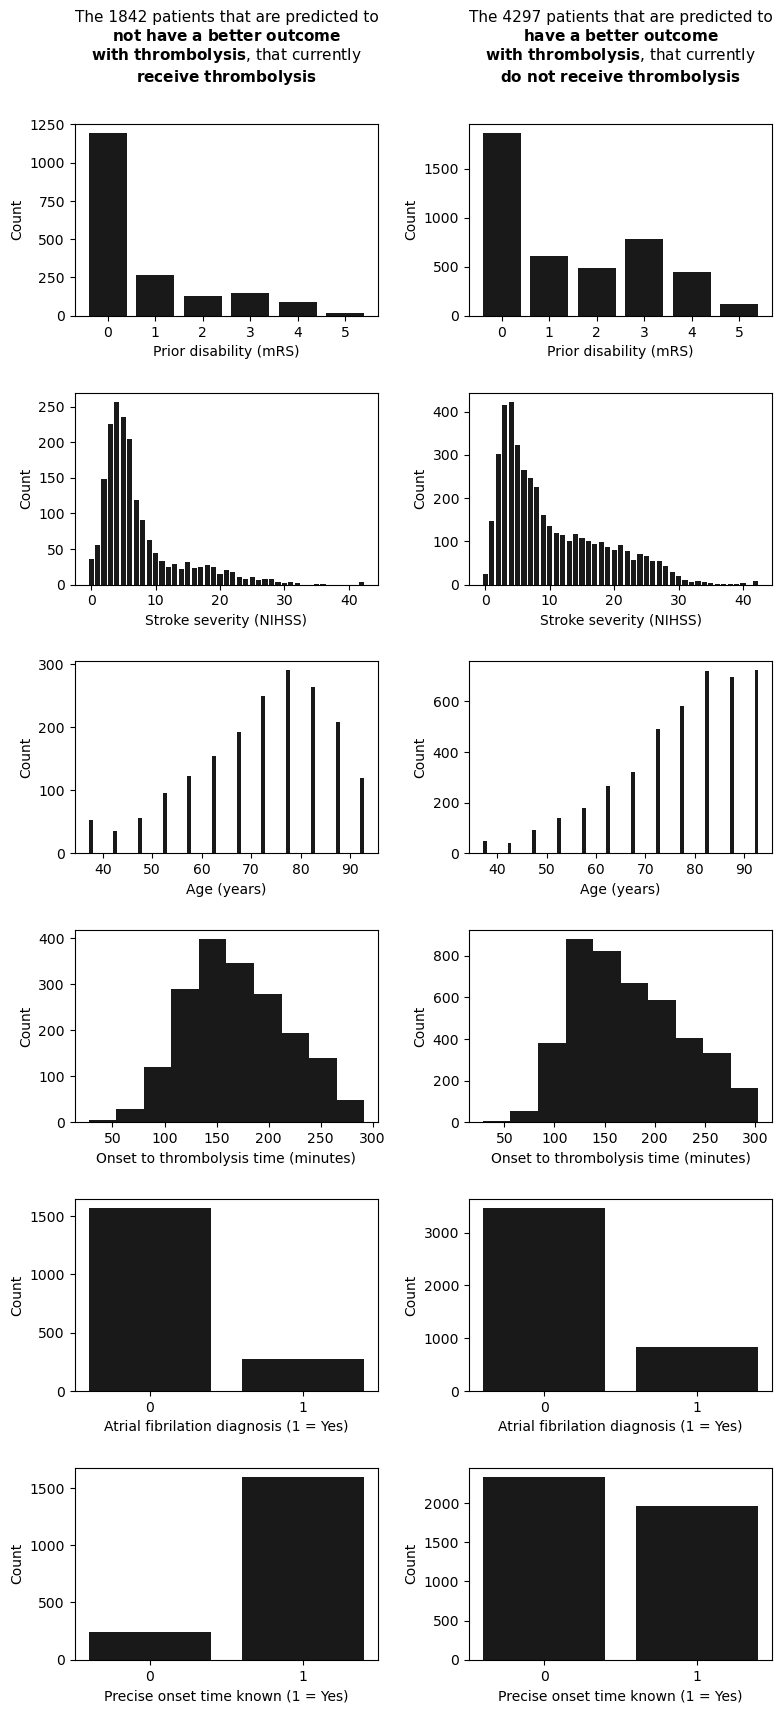

()

In [ ]:
scenarios_columns = ["Actual_treatment", "Lowest_weighted_mrs_and_least_mrs5_6"]
scenarios_short_name = ["Actual treatment", "Best outcome"]
scenarios_full_name = ["Actual treatment", 
                       "Lowest weighted mRS and least likely bad outcome (mRS 5-6)]"]

features_to_plot = copy.deepcopy(input_features)
features_to_plot.remove("stroke_team")

data_for_histogram["onset_to_thrombolysis_time"] = (test_all_treated_onset_to_thrombolysis_time)

create_histogram_figures_change_decision(df_treatment_decision_per_scenario, 
                                         data_for_histogram,
                                         features_to_plot,
                                         dict_feature_name,
                                         scenarios_columns)

1. Take the 17,948 patients in the first test set (includes patients that got MT and arrived within 240 minutes)
2. Load the XGBoost thrombolysis decision model (trained on the first k-fold training set in notebook 200).
3. Use the model, and send all the 17,948 patients to each hospital to predict their treatment decision (using thrombolysis decision model above)
4. Use the multiclass outcome model to get the two mRS distributions (with and without treatment) to predict which of the 17,948 patients should have thrombolysis based on the definition of a good outcome (for this experiment, use the hospital with the most neutral contribution to the prediction, this is number 25).
5. Calculate a comparative sensitivity and specificity for each hospital (as have the same patient cohort). Sensitivity: the proportion of patients that have a good outcome with treatment and got treated. Specificity: and the proportion of patients that do not have a good outcome with treatment and did not get treated.

In [ ]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 200 first to train the model")
    return(model)

In [ ]:
def calculate_specificity(best_decision, hospital_decision):
    """
    specificity: the proportion of patients that do not have a good outcome with 
        treatment and did not get treated
    """
    # Take just the patients that should not get treated
    mask = best_decision == 0
    return(1 - hospital_decision[mask].mean())

In [ ]:
def calculate_sensitivity(best_decision, hospital_decision):
    """
    Sensitivity: the proportion of patients that have a good outcome with
    treatment and got treated
    """

    # Take just the patients that should get treated
    mask = best_decision == 1
    return(hospital_decision[mask].mean())


Calculate whether each patient has a good outcome when it attends the neutral hospital

To identify the neutral hospital, in terms of effect on the patient outcome, select the hospital that has the most zero SHAP hospital value for the attended hospital. This was done in notebook 053: hospital anonymous nnumber 40.

In [ ]:
neutral_hospital_name = 'team_40'

###

# Create X data for all treated at neutral hospital
X_all_treated_hosp40 = copy.deepcopy(X)
X_all_treated_hosp40["onset_to_thrombolysis_time"] = (
                                test_all_treated_onset_to_thrombolysis_time)
X_all_treated_hosp40[ohe_stroke_team_feature_names] = 0
X_all_treated_hosp40[neutral_hospital_name] = 1

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated_hosp40 = model_outcome.predict_proba(X_all_treated_hosp40)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_all_treated_hosp40, weighted_mrs_all_treated_hosp40) = (
        calculate_population_outcome(y_outcome_probs_all_treated_hosp40, mrs_classes))

###

# Create X data for none treated at neutral hospital
X_none_treated_hosp40 = copy.deepcopy(X)
X_none_treated_hosp40["onset_to_thrombolysis_time"] = (
                                surrogate_time_for_no_thrombolysis)
X_none_treated_hosp40[ohe_stroke_team_feature_names] = 0
X_none_treated_hosp40[neutral_hospital_name] = 1

# Calculate and store predicted outcome probabilities
y_outcome_probs_none_treated_hosp40 = model_outcome.predict_proba(X_none_treated_hosp40)

# Calculate weighted outcome per patient, and for population
(ave_weighted_mrs_none_treated_hosp40, weighted_mrs_none_treated_hosp40) = (
        calculate_population_outcome(y_outcome_probs_none_treated_hosp40, mrs_classes))

###

# Store whether each patient is better with thrombolysis based on criteria 1
mask_lowest_weighted_mrs_hosp40 = weighted_mrs_all_treated_hosp40 < weighted_mrs_none_treated_hosp40

# Calculate the likelihood of being mRS5-6 with and without treatment
proportion_mrs5_6_all_treated_hosp40 = y_outcome_probs_all_treated_hosp40[:,5:].sum(axis=1)
proportion_mrs5_6_not_treated_hosp40 = y_outcome_probs_none_treated_hosp40[:,5:].sum(axis=1)

# Store whether each patient is better with thrombolysis based on criteria 2
mask_least_mrs5_6_hosp40 = (
            proportion_mrs5_6_all_treated_hosp40 < proportion_mrs5_6_not_treated_hosp40)

# Store whether each patient recieved thrombolysis in this scenario
mask_lowest_weighted_mrs_and_least_mrs5_6_hosp40 = (
                                mask_lowest_weighted_mrs_hosp40 * mask_least_mrs5_6_hosp40)

neutral_hospital_good_outcome_treatment_decision = mask_lowest_weighted_mrs_and_least_mrs5_6_hosp40 


In [ ]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('200_xgb_8_features_all_data_thrombolysis_decision.p'))

model = load_xgboost_model(filename)

# Get target categories from model
classes = model.classes_

treatment_decision_result = pd.DataFrame()

# Add column for whether it's the best decision to get treatment
treatment_decision_result["better_outcome_with_thrombolysis"] = (
                        neutral_hospital_good_outcome_treatment_decision)


sensitivity = []
specificity = []

for stroke_team in ohe_stroke_team_feature_names:
    # Send all patients to chosen stroke team
    X_test = data[input_features_treatment_decision_ohe].copy(deep=True)
    X_test[ohe_stroke_team_feature_names] = 0
    X_test[stroke_team] = 1

    treatment_decision_result[stroke_team] = model.predict(X_test)

    sensitivity.append(calculate_specificity(neutral_hospital_good_outcome_treatment_decision,
                                             model.predict(X_test)))
    specificity.append(calculate_sensitivity(neutral_hospital_good_outcome_treatment_decision,
                                             model.predict(X_test)))

In [ ]:
def identify_pareto_front(scores_for_pareto, utopia="top_right"):
    """
    Identified parteto front for numpy array of scores.
    For any scores where 'lower is better' invesre of score should be used
    """
    population_size = scores_for_pareto.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)

    if utopia == "top_right":
        for i in range(population_size):
            for j in range(population_size):
                if all(scores_for_pareto[j] >= scores_for_pareto[i]) and any(
                        scores_for_pareto[j] > scores_for_pareto[i]):
                    # j dominates i
                    pareto_front[i] = 0
                    break
    elif utopia == "bottom_left":
        for i in range(population_size):
            for j in range(population_size):
                if all(scores_for_pareto[j] <= scores_for_pareto[i]) and any(
                        scores_for_pareto[j] < scores_for_pareto[i]):
                    # j dominates i
                    pareto_front[i] = 0
                    break
    else:
        print("Check utopia value")

    return (pareto_front)

In [ ]:
def plot_sensitivity_specificity(df, names=False):

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot()
    ax.scatter(df["sensitivity"], df["specificity"], s=10, c="k", alpha=0.4, edgecolors="grey")
    ax.set_xlabel(r"$\bf{Sensitivity}$" + " " + r"$\bf{of}$" + " " + r"$\bf{treatment}$" + f" (proportion of patients who\nwould benefit from treatment who are treated)", fontsize=12)
    ax.set_ylabel(r"$\bf{Specificity}$" + " " + r"$\bf{of}$" + " " + r"$\bf{treatment}$" + f" (proportion of patients who\nwould not benefit from treatment who are not treated)", fontsize=12)

    if names:
        # label some points to check position
        for i, txt in enumerate(df.index[:10]):
            plt.annotate(txt, (df["sensitivity"][i], df["specificity"][i]))


    # plot pareto
    pareto_front = identify_pareto_front(df.values, utopia="top_right")
    df_hosp_shap_pareto_front = df[pareto_front]
    plt.scatter(df_hosp_shap_pareto_front["sensitivity"],df_hosp_shap_pareto_front["specificity"], s=10, c="k")

    # line between points
    df_hosp_shap_pareto_front = df_hosp_shap_pareto_front.sort_values("sensitivity")
    for i in range(df_hosp_shap_pareto_front.shape[0]-1):
        plt.plot(df_hosp_shap_pareto_front.values[i:i+2,0], df_hosp_shap_pareto_front.values[i:i+2, 1], c="k", linestyle="--")

    plt.xlim(0.5,1)
    plt.ylim(0.2,0.8)
    plt.tick_params(labelsize=12)

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                        '_spec_sens.jpg'))

    plt.savefig(filename, dpi=300)
    
    plt.show()
    return()

In [ ]:
df_stroke_team_sens_spec = pd.DataFrame()
df_stroke_team_sens_spec["sensitivity"] = sensitivity
df_stroke_team_sens_spec["specificity"] = specificity
df_stroke_team_sens_spec.index = ohe_stroke_team_feature_names
df_stroke_team_sens_spec

,sensitivity,specificity
team_1,0.802296,0.529337
team_2,0.620890,0.681470
team_3,0.816610,0.458488
team_4,0.772392,0.473098
team_6,0.604308,0.748724
...,...,...
team_113,0.802012,0.473330
team_114,0.804705,0.453966
team_116,0.723639,0.615492
team_117,0.753401,0.562036


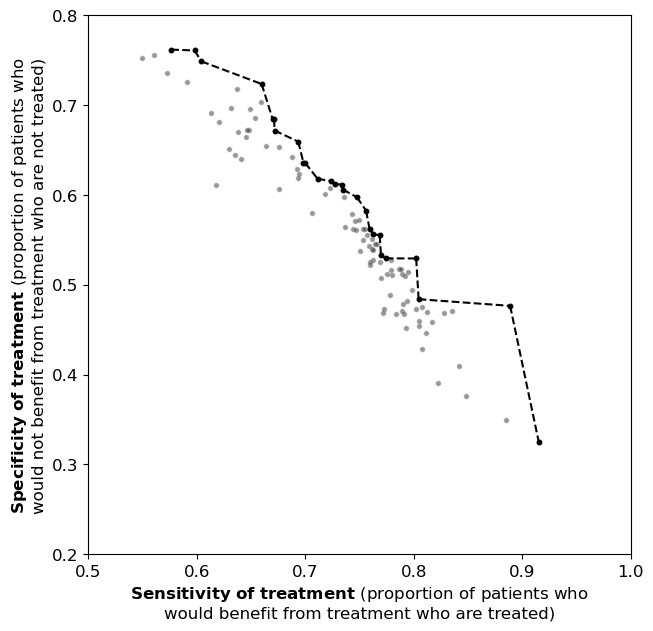

()

In [ ]:
plot_sensitivity_specificity(df_stroke_team_sens_spec, names=False)

Venn diagram. Displaying values as per 100 patients.

In [ ]:
def create_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, venn_diagram_xticks,
                        filename="", title_prefix="", title_suffix="", ax=None,
                        represent_as_100=False):
    
    """
    df_treatment_decision_per_scenario []: 
    venn_diagram_columns []:
    venn_diagram_xticks []:
    filename []:
    title_prefix []:
    title_suffix []:
    ax []:
    represent_as_100 [boolean]:
    
    """
    # Put data in required format for venn diagram (a list of sets, with each set
    # containing the patient index numbers that recieve IVT in that scenario)

    total = df_treatment_decision_per_scenario.shape[0]

    # Initialise lists
    list_vd_sets = []
    labels = []

    ax = ax or plt.gca()

    # For each scenario to be shown in the venn diagram
    for col, label in zip (venn_diagram_columns, venn_diagram_xticks):
        # Mask those patients that get treatment in that scenario
        mask = df_treatment_decision_per_scenario[col]==1
        list_vd_sets.append(set(df_treatment_decision_per_scenario[mask].index))
        count_ivt = df_treatment_decision_per_scenario[col].sum()
        if represent_as_100:
            count_ivt = (count_ivt/total)*100
        labels.append(label +  f"\n({count_ivt:.0f} patients)")

    if len(venn_diagram_columns) == 2:
        # Create venn diagram
        if represent_as_100:
            venn2(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue'), 
                alpha = 0.7,
                subset_label_formatter=lambda x: f"{((x/total)*100):.0f}");
        else:
            venn2(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue'), alpha = 0.7);

        venn2_circles(list_vd_sets, linewidth=0.5, color='k');

    elif len(venn_diagram_columns) == 3:
        if represent_as_100:
            venn3(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue', 'mediumorchid'), 
                alpha = 0.7,
                subset_label_formatter=lambda x: f"{((x/total)*100):.0f}");
        else:
            venn3(list_vd_sets, labels, set_colors=('yellow', 'deepskyblue', 'mediumorchid'), alpha = 0.7);
        venn3_circles(list_vd_sets, linewidth=0.5, color='k');
    
    else:
        print("Can only plot venn with 2 or 3 subgroups")

    # Calculate the number of patients treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) > 0
    n_patients_treated_any = mask.sum()

    # Calculate the number of patients not treated across any scenario
    mask = df_treatment_decision_per_scenario[venn_diagram_columns].sum(axis=1) == 0
    n_patients_not_treated_any = mask.sum()

    if represent_as_100:
        n_patients_not_treated_any = str(int((n_patients_not_treated_any / total) * 100)) + " patients"
        n_patients_treated_any = str(int((n_patients_treated_any / total) * 100)) + " patients"

    # Add title
    plt.title(f"{title_prefix}* {n_patients_treated_any} patients treated in any scenario"
            f"\n* {n_patients_not_treated_any} patients not treated in any scenario"
            f"\n{title_suffix}", fontsize=18, pad=30)
    
    if len(filename)>0:
        plt.savefig(filename, dpi=300)

    return(ax)

In [ ]:
list_venn_diagram_columns = [["Actual_treatment", "Lowest_weighted_mrs"],
                             ["Actual_treatment", "Least_mrs5_6"],
                             ["Actual_treatment", "Lowest_weighted_mrs_and_least_mrs5_6"],
                             ["Actual_treatment", "Weighted_mrs_threshold_improvement"],
                             ["Actual_treatment", "Weighted_mrs_threshold_improvement_and_least_mrs5_6"]]
list_xticks = []
for venn_diagram_columns in list_venn_diagram_columns:
    xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]
    list_xticks.append(xticks)

fig = plt.figure(figsize=(28,22))

fig.suptitle("Agreement on which patients to treat (actual decisions compared with an increasingly conservative definition of a 'best outcome')", fontsize=20)

for subplot, (venn_diagram_columns, xticks) in enumerate(zip(list_venn_diagram_columns, list_xticks)):
    ax1 = fig.add_subplot(2,3,subplot+1)

    create_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, xticks, ax=ax1, represent_as_100=False)
    
  
fig.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        f'_venn_diagram_actual_treatment_vs_scenarios.jpg'))

plt.savefig(filename, dpi=300)

In [ ]:
list_venn_diagram_columns = [["Actual_treatment", "Lowest_weighted_mrs_and_least_mrs5_6"]]
list_xticks = []
for venn_diagram_columns in list_venn_diagram_columns:
    xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in venn_diagram_columns]
    list_xticks.append(xticks)

fig = plt.figure(figsize=(28,22))

fig.suptitle("100 stroke patients arriving in time for thrombolysis treatment."
             "\nAgreement on which patients to treat (actual decisions "
             "compared with an increasingly conservative definition of a "
             "'best outcome')", fontsize=20)

for subplot, (venn_diagram_columns, xticks) in enumerate(zip(list_venn_diagram_columns, list_xticks)):
    ax1 = fig.add_subplot(2,3,subplot+1)

    create_venn_diagram(df_treatment_decision_per_scenario, 
                        venn_diagram_columns, xticks, ax=ax1, represent_as_100=True)
    
  
fig.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                        f'_venn_diagram_actual_decision_vs_scenarios_100patients.jpg'))

plt.savefig(filename, dpi=300)

What proportion of stroke severitys have a benefit from thrombolysis treatment?

In [ ]:
column = "Lowest_weighted_mrs_and_least_mrs5_6"
df = pd.DataFrame()
df["stroke_severity"] = data["stroke_severity"].values
df[column] = df_treatment_decision_per_scenario[column].values

outcome_by_nihss = df.groupby("stroke_severity")[column].mean()
count_by_nihss = df.groupby("stroke_severity")["stroke_severity"].count()

fig = plt.figure(figsize=(8,8))


ax = fig.add_subplot(1, 1, 1)
ax.plot(outcome_by_nihss.index, outcome_by_nihss.values)

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
count_by_nihss.plot(kind='bar', ax=ax2, width=1, position=0, alpha=0.1, color="k")

ax.set_xlabel("Stroke severity (NIHSS)")
ax.set_ylabel("Proportion of patients with improved outcome")
ax2.set_ylabel("Count of patients")
ax.set_title("Improved outcome with thrombolysis by stroke severity")
ax.set_xlim(0,15)
ax.set_xticks(np.arange(0,16,1))
ax.grid()
plt.show()

Criteria values (needed, or already covered above?)

In [ ]:
# Create mask to extract the population sample: should get treated
mask_should_treat = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"].astype(bool).values
mask_should_not_treat = ~mask_should_treat

mask_actually_treated = df_treatment_decision_per_scenario["Actual_treatment"].astype(bool).values
mask_actually_not_treated = ~mask_actually_treated

# Get the X data
X_should_but_not = copy.deepcopy(X)[mask_should_treat * mask_actually_not_treated]
X_should_not_but_given = copy.deepcopy(X)[mask_should_not_treat * mask_actually_treated]

In [ ]:
X_should_but_not.describe()

,prior_disability,stroke_severity,age,onset_to_thrombolysis_time,any_afib_diagnosis,precise_onset_known,team_1,team_2,team_3,team_4,...,team_108,team_109,team_110,team_111,team_112,team_113,team_114,team_116,team_117,team_118
count,4297.000000,4297.000000,4297.000000,4297.0,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,...,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000
mean,1.462183,10.292995,77.116011,9999.0,0.193391,0.456830,0.013498,0.007447,0.005353,0.008145,...,0.006283,0.007214,0.009774,0.008843,0.005120,0.009774,0.005353,0.006516,0.001629,0.004422
std,1.559952,8.009365,13.006198,0.0,0.395003,0.498191,0.115407,0.085984,0.072974,0.089893,...,0.079028,0.084640,0.098392,0.093633,0.071378,0.098392,0.072974,0.080469,0.040333,0.066356
min,0.000000,0.000000,37.500000,9999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,67.500000,9999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,8.000000,77.500000,9999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,15.000000,87.500000,9999.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,42.000000,92.500000,9999.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'Weighted mRS if treated')

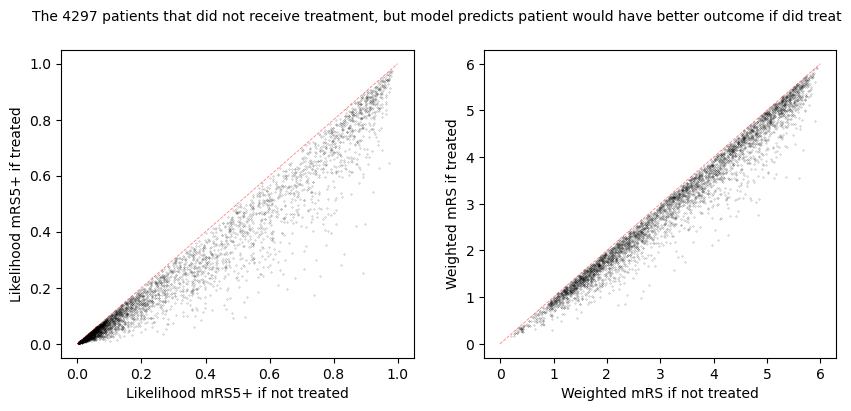

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle(f"The {mask_not_actual_but_best.sum()} patients that did not receive treatment, but model predicts patient would have better outcome if did treat",
             fontsize=10)


ax1.scatter(proportion_mrs5_6_not_treated[mask_not_actual_but_best],
            proportion_mrs5_6_all_treated[mask_not_actual_but_best],
            s=0.05,  alpha=0.5,  color="k")
ax1.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax1.set_xlabel("Likelihood mRS 5-6 if not treated")
ax1.set_ylabel("Likelihood mRS 5-6 if treated")


ax2.scatter(weighted_mrs_none_treated[mask_not_actual_but_best],
            weighted_mrs_all_treated[mask_not_actual_but_best],
            s=0.05,  alpha=0.5,  color="k")
ax2.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax2.set_xlabel("Weighted mRS if not treated")
ax2.set_ylabel("Weighted mRS if treated")


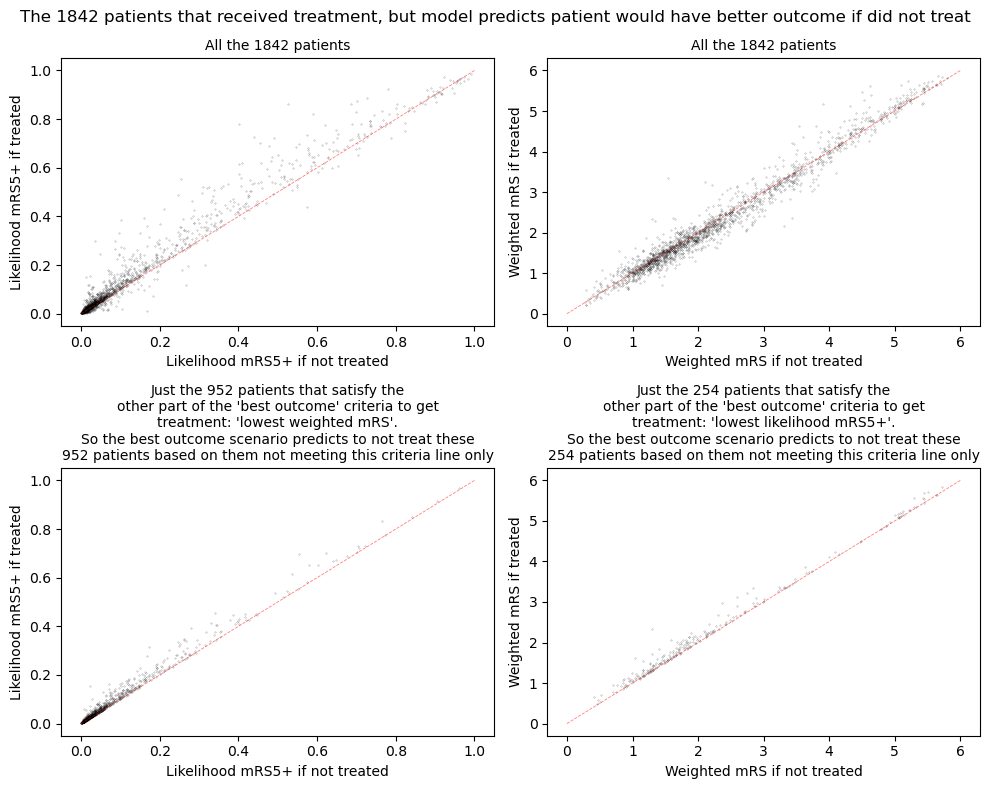

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle(f"The {mask_actual_but_not_best.sum()} patients that received treatment, but model predicts patient would have better outcome if did not treat",
             fontsize=12)


ax1.scatter(proportion_mrs5_6_not_treated[mask_actual_but_not_best],
            proportion_mrs5_6_all_treated[mask_actual_but_not_best],
            s=0.05,  alpha=0.5,  color="k")
ax1.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax1.set_xlabel("Likelihood mRS 5-6 if not treated")
ax1.set_ylabel("Likelihood mRS 5-6 if treated")
ax1.set_title(f"All the {mask_actual_but_not_best.sum()} patients", fontsize=10)

ax2.scatter(weighted_mrs_none_treated[mask_actual_but_not_best],
            weighted_mrs_all_treated[mask_actual_but_not_best],
            s=0.05,  alpha=0.5,  color="k")
ax2.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax2.set_xlabel("Weighted mRS if not treated")
ax2.set_ylabel("Weighted mRS if treated")
ax2.set_title(f"All the {mask_actual_but_not_best.sum()} patients", fontsize=10)

# Wanted to see graphs showing benefit when no treatment.

# But as it's 2 criteria to satify, then if fail to meet 1, then should meet the other.
# As need to satifsfy two criteria for treatment to be classed as giving "best outcome" (weighted, and mRS5+) then the values of each of these for those that not treated

mask = mask_actual_but_not_best * mask_lowest_weighted_mrs
ax3.scatter(proportion_mrs5_6_not_treated[mask],
            proportion_mrs5_6_all_treated[mask],
            s=0.05,  alpha=0.5,  color="k")
ax3.plot((0,1),(0,1),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax3.set_xlabel("Likelihood mRS 5-6 if not treated")
ax3.set_ylabel("Likelihood mRS 5-6 if treated")
ax3.set_title(f"Just the {mask.sum()} patients that satisfy the\nother part of the "
              f"'best outcome' criteria to get\ntreatment: 'lowest weighted mRS'.\n"
              f"So the best outcome scenario predicts to not treat these\n{mask.sum()} "
              f"patients based on them not meeting this criteria line only", 
              fontsize=10)

mask = mask_actual_but_not_best * mask_least_mrs5_6
ax4.scatter(weighted_mrs_none_treated[mask],
            weighted_mrs_all_treated[mask],
            s=0.05,  alpha=0.5,  color="k")
ax4.plot((0,6),(0,6),color='red', linestyle='--', linewidth=.6, alpha=0.5)
ax4.set_xlabel("Weighted mRS if not treated")
ax4.set_ylabel("Weighted mRS if treated")
ax4.set_title(f"Just the {mask.sum()} patients that satisfy the\nother part of the "
              f"'best outcome' criteria to get\ntreatment: 'lowest likelihood mRS5+'."
              f"\nSo the best outcome scenario predicts to not treat these\n{mask.sum()} "
              f"patients based on them not meeting this criteria line only", 
              fontsize=10)

fig.tight_layout()


In [ ]:
net_change_mrs5_6 = (proportion_mrs5_6_all_treated - proportion_mrs5_6_not_treated)
net_change_weighted_mrs = (weighted_mrs_all_treated - weighted_mrs_none_treated)

mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs > 0
mask_neither = mask1 * mask2

mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs > 0
mask_mrs5_6_only = mask1 * mask2

mask1 = net_change_mrs5_6 > 0 
mask2 = net_change_weighted_mrs < 0
mask_weighted_mrs_only = mask1 * mask2

mask1 = net_change_mrs5_6 < 0 
mask2 = net_change_weighted_mrs < 0
mask_both = mask1 * mask2

<function matplotlib.pyplot.show(close=None, block=None)>

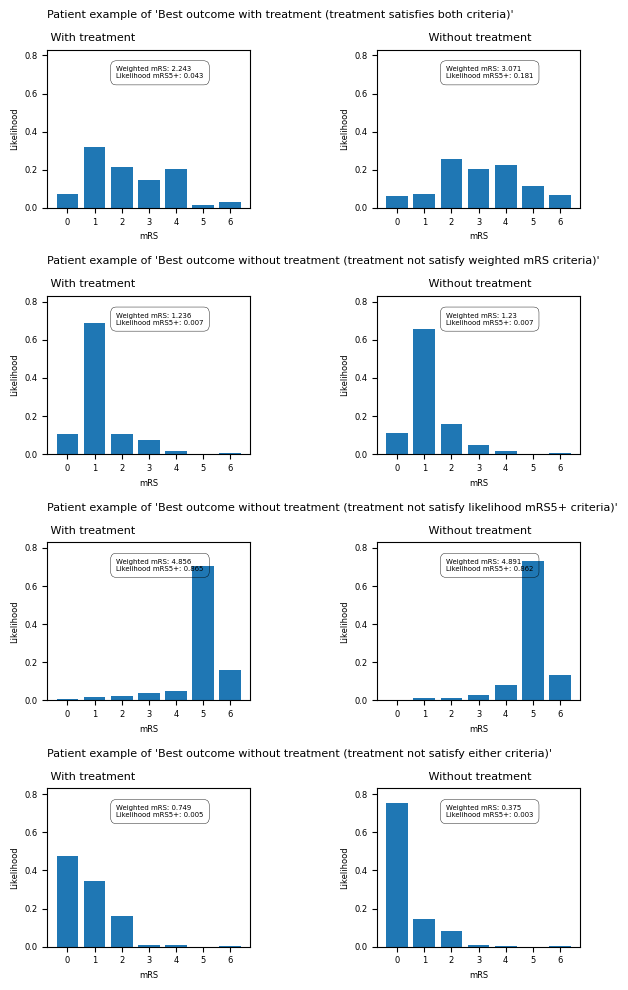

In [ ]:
p_ids = []
p_ids.append(np.where(mask_both == 1)[0][0])
p_ids.append(np.where(mask_mrs5_6_only == 1)[0][0])
p_ids.append(np.where(mask_weighted_mrs_only == 1)[0][0])
p_ids.append(np.where(mask_neither == 1)[0][0])

fig, axes = plt.subplots(4,2, figsize=(6,10))

y_max = max(y_outcome_probs_all_treated[p_ids].max(), 
            y_outcome_probs_none_treated[p_ids].max())

x_max = max(mrs_classes)

treatment_title = ["With treatment", "Without treatment"]
patient_title = ["Patient example of 'Best outcome with treatment (treatment satisfies both criteria)'", 
                 "Patient example of 'Best outcome without treatment (treatment not satisfy weighted mRS criteria)'", 
                 "Patient example of 'Best outcome without treatment (treatment not satisfy likelihood mRS 5-6 criteria)'",
                 "Patient example of 'Best outcome without treatment (treatment not satisfy either criteria)'"]

for (row, p_id) in enumerate(p_ids):
    axes[row,0].bar(mrs_classes, y_outcome_probs_all_treated[p_id])
    axes[row,0].text(x_max*0.3, y_max*0.9, 
                       f"Weighted mRS: {round(weighted_mrs_all_treated[p_id],3)}\nLikelihood mRS 5-6: {str(round(proportion_mrs5_6_all_treated[p_id],3))}", 
                       fontsize=5, color='k', 
                       bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                                 boxstyle='round', pad=0.8))

    axes[row,0].set_title(f"{patient_title[row]}\n\n {treatment_title[0]}", fontsize=8, loc="left")

    axes[row,1].bar(mrs_classes, y_outcome_probs_none_treated[p_id])
    axes[row,1].text(x_max*0.3, y_max*0.9, 
                       f"Weighted mRS: {round(weighted_mrs_none_treated[p_id], 3)}\nLikelihood mRS 5-6: {str(round(proportion_mrs5_6_not_treated[p_id],3))}", 
                       fontsize=5, color='k', 
                       bbox=dict(facecolor='none', edgecolor='k',linewidth=0.3, 
                                 boxstyle='round', pad=0.8))
    axes[row,1].set_title(f"\n\n {treatment_title[1]}", fontsize=8)

    for col in range(2):
        axes[row,col].set_ylim(0,y_max*1.1)
        axes[row,col].set_xlabel("mRS", fontsize=6)
        axes[row,col].set_ylabel("Likelihood", fontsize=6)
        axes[row,col].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row,col].set_xticklabels(axes[row,col].get_xticklabels(), fontsize=6)
        axes[row,col].set_yticklabels(axes[row,col].get_yticklabels(), fontsize=6)

plt.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_4_patient_examples_mrs_distribution.jpg'))

plt.savefig(filename, dpi=300)

plt.show

# NEED ANYTHING ONWARDS? As now showing this information in a simpler way (using treatment decision model)

## Run two experiments.

1. Of the patients that should get treated (the population sample), fit a model to predict if each patient is treated from the patient characteristics. See the difference in the patients between the two groups. What's different for those patients that are not treated, but should. (where 0 = Not treated, incorrect decision and 1 = Treated, correct decision)

2. Of the patients that should not get treated (the population sample), fit a model to predict if each patient is treated from the patient characteristics. See the difference in the patients between the two groups. What's different for those patients that are treated, but should not be. (where 0 = Treated, incorrect decision and 1 = Not treated, correct decision)

In [ ]:
s1_name = "Lowest_weighted_mrs_and_least_mrs5_6"
s2_name = "Actual_treatment"

In [ ]:
def switch_0_and_1(y):
    where_1 = np.where(y == 1)
    where_0 = np.where(y == 0)
    y[where_0] = 1
    y[where_1] = 0
    return(y)

## Fit model to predict if get treatment, of those that should.

Of the patients that should get treated predict whether get treated.

* 0 = Not treated, incorrect decision
* 1 = Treated, correct decision

In [ ]:
# Create mask to extract the population sample: should get treated
mask_should_treat = df_treatment_decision_per_scenario[s1_name].astype(bool).values

# Get the X data
X_should = copy.deepcopy(X)
X_should["onset_to_thrombolysis_time"] = test_and_mt_all_treated_onset_to_thrombolysis_time
X_should = X_should[mask_should_treat]

# Get the y data
# "0" = should treat, do not (incorrect), "1" = should treat and are (correct)
y_should = df_treatment_decision_per_scenario[s2_name][mask_should_treat].values

NameError: name 'test_and_mt_all_treated_onset_to_thrombolysis_time' is not defined

In [ ]:
mask_should_treat.sum()

12211

In [ ]:
def create_train_test_split(filename, X, y, test_size=0.25):

    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load data
        with open(filename, 'rb') as filehandler:
            dict = pickle.load(filehandler)
            
        X_train = dict["X_train"]
        X_test = dict["X_test"]
        y_train = dict["y_train"]
        y_test = dict["y_test"]

    else:
        # Create
        (X_train, X_test, y_train, y_test) = (
                            train_test_split(X, y, test_size=test_size))
        
        # And store in dictionary, to save
        dict = {}
        dict["X_train"] = X_train
        dict["X_test"] = X_test
        dict["y_train"] = y_train
        dict["y_test"] = y_test
    
        # Save
        with open(filename, 'wb') as filehandler:
            pickle.dump(dict, filehandler)
            
    return(X_train, X_test, y_train, y_test)

In [ ]:
# Set up or load test and train data
filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + 'dictionary_train_test_should.p'))

(X_train_should, X_test_should, y_train_should, y_test_should) = (
                        create_train_test_split(filename, X_should, y_should, test_size=0.25))

Extract the team name attended for each patient

In [ ]:
stroke_team_test_should = X_test_should[ohe_stroke_team_feature_names].idxmax(axis=1)
stroke_team_test_should = [s.replace('team_', '') for s in stroke_team_test_should]

Create functions

In [ ]:
def create_xgboost_model(filename, X_train, y_train):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else return that user needs to run notebook 040 to create the model.

    Arg:
        filename [string]: where xgboost model is saved

    Return:
        model [model object]: xgboost classification model 
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
    # Create and save
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train)

        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
            
    return(model)

In [ ]:
def plot_cm(cm):

    fig, ax = plt.subplots(1,1)

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, ax=ax, alpha=0.5, label='Count')

    # Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    # Set axis titles
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')
    plt.show()

    return()

In [ ]:
def create_coefficient_df(model, feature_names):
    coeff = model.coef_[0]
    coeff_df = pd.DataFrame() # create empty DataFrame
    coeff_df['feature'] = feature_names # Get feature names from X
    coeff_df['coeff'] = coeff
    coeff_df['abs_coeff'] = np.abs(coeff)
    coeff_df.sort_values(by='abs_coeff', ascending=False, inplace=True)
    return(coeff_df)

Receiver operating characteristic (ROC) Curve
We calculate the ROC curve by adjusting the probability cut-off (the probability cut-off of someone surviving in order to classify them as a survivor). Here we create a loop with cut-off probabilities in the range 0-1 in steps of 0.01. We do not need to refit the model – we take the same prediction probabilities output and apply varying cut-off thresholds to that output.

Calculating area of ROC
A common measurement from the ROC curve is to measure the area under the curve. A model that performs no better than guessing by random chance will have an area of 0.5. A perfect model will have an area of 1.0.
sklearn has a method for calculating the ROC area-under-curve, that we will use.

In [ ]:
# Define a function for plotting the ROC curve
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    roc_auc = auc(fpr, tpr)
    plt.title(f'Receiver Operator Characteristic (ROC) Curve\n[ROCAUC: {roc_auc:0.3}]')
    plt.grid(True)
    plt.legend()
    plt.show()
    return()

XGBoost

In [ ]:
# Set up and fit model
filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + '_should.p'))
model_xgb_should = create_xgboost_model(filename, X_train_should, y_train_should)

# Predict training and test set labels
y_pred_train_xgb_should = model_xgb_should.predict(X_train_should)
y_pred_test_xgb_should = model_xgb_should.predict(X_test_should)

# Calculate accuracy of training and test sets
accuracy_train_should = np.mean(y_pred_train_xgb_should == y_train_should)
accuracy_test_should = np.mean(y_pred_test_xgb_should == y_test_should)

print ('Accuracy of predicting training data =', accuracy_train_should)
print ('Accuracy of predicting test data =', accuracy_test_should)

Accuracy of predicting training data = 0.8636165101550557
Accuracy of predicting test data = 0.7432034064854242


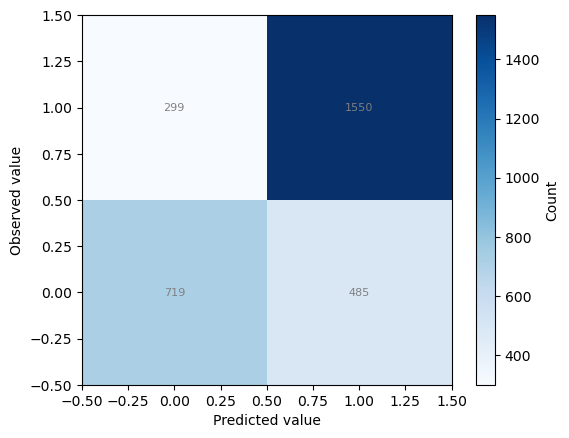

()

In [ ]:
plot_cm(confusion_matrix(y_test_should, y_pred_test_xgb_should))

In [ ]:
# Show first ten predicted probabilities 
# (note how the values relate to the classes predicted above)
probabilities_xgb = model_xgb_should.predict_proba(X_test_should)

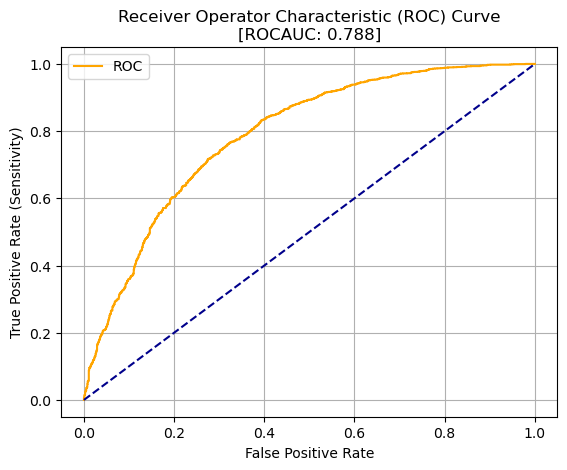

()

In [ ]:
# Get ROC curve using sklearn method
fpr, tpr, thresholds = roc_curve(y_test_should, probabilities_xgb[:,1]) 

# Plot ROC curve
plot_roc_curve(fpr, tpr)

SHAP

Create function to return SHAP values extension X and y data for train and test sets

In [ ]:
def calculate_shap_extended(model, X_train, X_test, filename, explainer_filename):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """


    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

In [ ]:
# Set filename
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                            f'_shap_values_extended_should_{s1_name}_{s2_name}.p'))

explainer_filename = os.path.join(paths.data_save_path, 
                    (paths.notebook + paths.model_text + 
                        f'_shap_explainer_should_{s1_name}_{s2_name}.p'))

# Get and store SHAP values
shap_values_extended_should = calculate_shap_extended(model_xgb_should, X_train_should, X_test_should, 
                                               filename, explainer_filename)
shap_values_should = shap_values_extended_should.values

In [ ]:
# Get and store feature importances
shap_feature_importance_df = pd.DataFrame() # create empty DataFrame
shap_feature_importance_df['feature'] = list(X) # Get feature names from X
shap_feature_importance_df['importance'] = model_xgb_should.feature_importances_
shap_feature_importance_df['abs(mean shap)'] = abs(shap_values_should.mean(axis=0))
shap_feature_importance_df['mean(abs shap)'] = abs(shap_values_should).mean(axis=0)
shap_feature_importance_df.sort_values(by='mean(abs shap)', ascending=False, inplace=True)

shap_feature_importance_df.head(20)

,feature,importance,abs(mean shap),mean(abs shap)
1,stroke_severity,0.015856,0.063943,0.695097
5,precise_onset_known,0.064143,0.078736,0.600820
0,prior_disability,0.018672,0.064293,0.535074
3,onset_to_thrombolysis_time,0.007678,0.007628,0.427637
2,age,0.006779,0.005503,0.227510
4,any_afib_diagnosis,0.005213,0.006957,0.045073
61,team_56,0.006832,0.022598,0.040140
33,team_28,0.015638,0.021421,0.031714
117,team_112,0.008532,0.025576,0.029215
46,team_41,0.008181,0.015983,0.026755


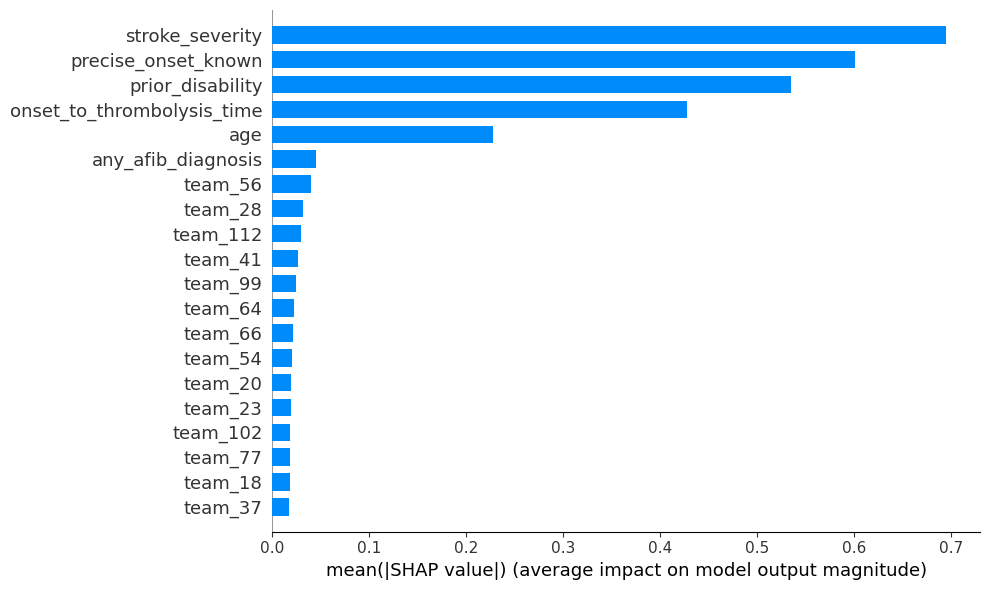

In [ ]:
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_should, X_test_should.values, plot_type="bar", 
                  class_names=model_xgb_should.classes_, 
                  feature_names = list(X), class_inds="original",
                  show=False, plot_size=(10,6))

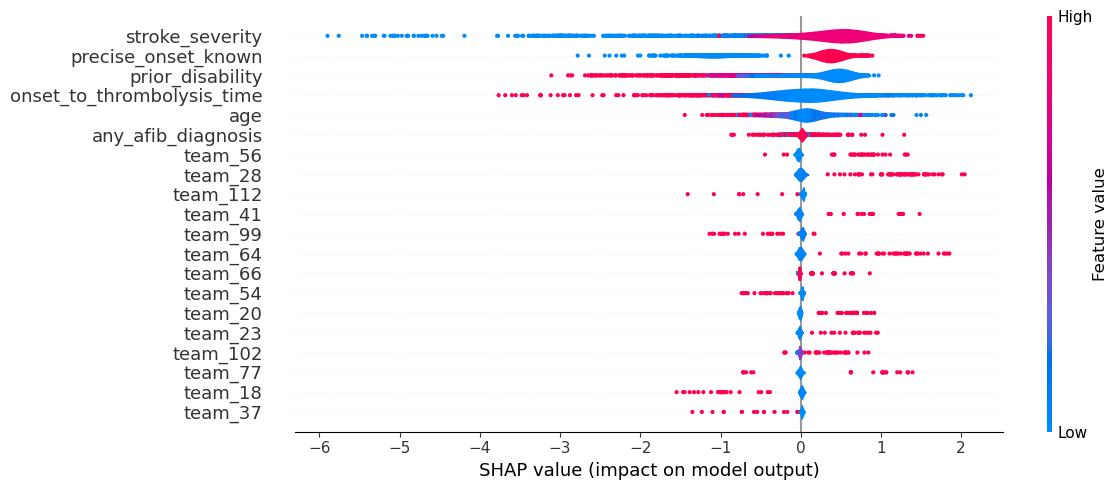

In [ ]:
shap.summary_plot(shap_values_should, X_test_should.values, 
                    feature_names=X_test_should.columns, show=False, 
                    plot_size=(12,5), plot_type='violin')

Show the relationship between feature value and SHAP value for the top 6 influential features
(as violin plots)

Resource: https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0 https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [ ]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

In [ ]:
def create_grid_of_violin_plots(features_violin, 
                                shap_values_extended,
                                title,
                                filename,
                                show_zero_shap=True
                                ):
    """
    Create a grid of violin plots (with each violin plot showing the 
    relationship between feature value and its SHAP value.

    Depending on the feature, there are some special cases for the plot layout.
   
    Args:
        features_violin [list]: list of features to create a violin plot
        class_category [integer]: the class to show
        shap_values_extended [shap_values variable]: shap values for a kfold
                (with three attributes: .values, .base_values and .data)
        
    Return:
        None
    
    """
    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # Create figure
    fig = plt.figure(figsize=(12,14), constrained_layout=True)


    fig.suptitle(title, 
                 fontsize=20)

    # A subplot showing violin plot for each feature.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Determine number of rows of subplots by rounding up
    ncols = 2
    nrows = math.ceil(len(features_violin)/ncols)

    # Through each feature
    for n, feat in enumerate(features_violin):    
        
        # Get data and SHAP values
        feature_data = shap_values_extended[:, feat].data
        feature_shap = shap_values_extended[:, feat].values

        # If feature has more that 50 unique values, then assume it needs to be 
        # binned (otherwise assume they are unique categories)

        if np.unique(feature_data).shape[0] > 50:
            # bin the data, create a violin per bin
            
            # settings for the plot
            rotation = 45
            step = 30
            n_bins = min(11, np.int((feature_data.max())/step))
            
            # create list of bin values
            bin_list = [(i*step) for i in range(n_bins)]
            bin_list.append(feature_data.max())
            if feat == "onset_to_thrombolysis_time" and feature_data.min() < 0:
                # for -100 for no IVT
                bin_list.insert(0, feature_data.min())

            # Number of instances per bin
            counts, edges = np.histogram(feature_data, bins=bin_list, density=False)

            # create list of bins (the unique categories)
            category_list = [f'{i*step}-{((i+1)*step-1)}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
            category_list.append(f'{(n_bins-1)*step}+\n[n={int(counts[-1])}]')
            if feat == "onset_to_thrombolysis_time" and feature_data.min() < 0:
                # for -100 for no IVT
                category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}]')

            # bin the feature data
            feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                right=False)

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])

        else:
            # create a violin per unique value
            
            # settings for the plot
            rotation = 90
            
            # create list of unique categories in the feature data
            category_list = np.unique(feature_data)

            # Age needs to keep its decimal value (midpoint between 5 yrs)
            if feat != 'age':
                category_list = [int(i) for i in category_list]

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            count = []
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])
                count.append(mask.sum())

            if feat == 'age':
                # create text of x ticks
                category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

                # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
                #   the other ages). To accommodate this, if last age category is "110"
                #   then overwrite the label with the correct band (100-120), and not
                #   107-112 as the above code would create.
                if category_list[-1] == '107-112':
                    category_list[-1] = '100-120'
            if feat == 'stroke_severity':
                # not enough space of chart for 2 lines fo x tick labels
                category_list = [f'{category_list[i]} [n={count[i]}]' for i in range(len(category_list))]
            else:
                category_list = [f'{category_list[i]}\n[n={count[i]}]' for i in range(len(category_list))]

        # create violin plot
        ax = fig.add_subplot(nrows,ncols,n+1)

        nans = [float('nan'), float('nan')] # requires at least 2 nans

        ax.violinplot([val if val.any() else nans for val in shap_per_category], 
                       showmeans=True, widths=0.9, showextrema=False)

        if show_zero_shap:
            # Add line at Shap = 0
            feature_values = shap_values_extended[:, feat].data
            ax.plot([0, len(feature_values)], [0,0],c='0.5')   

        # customise the axes
        ax = set_ax(ax, category_list, feat, rotation=rotation)
        plt.subplots_adjust(bottom=0.15, wspace=0.05)

        # Adjust stroke severity tickmarks
        if feat == 'Stroke severity':
            ax.set_xticks(np.arange(1, len(category_list)+1, 2))
            ax.set_xticklabels(category_list[0::2])   
            
        # Add title
        ax.set_title(feat)
        
    plt.tight_layout(pad=2)
        
    fig.savefig(filename, 
                dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return()

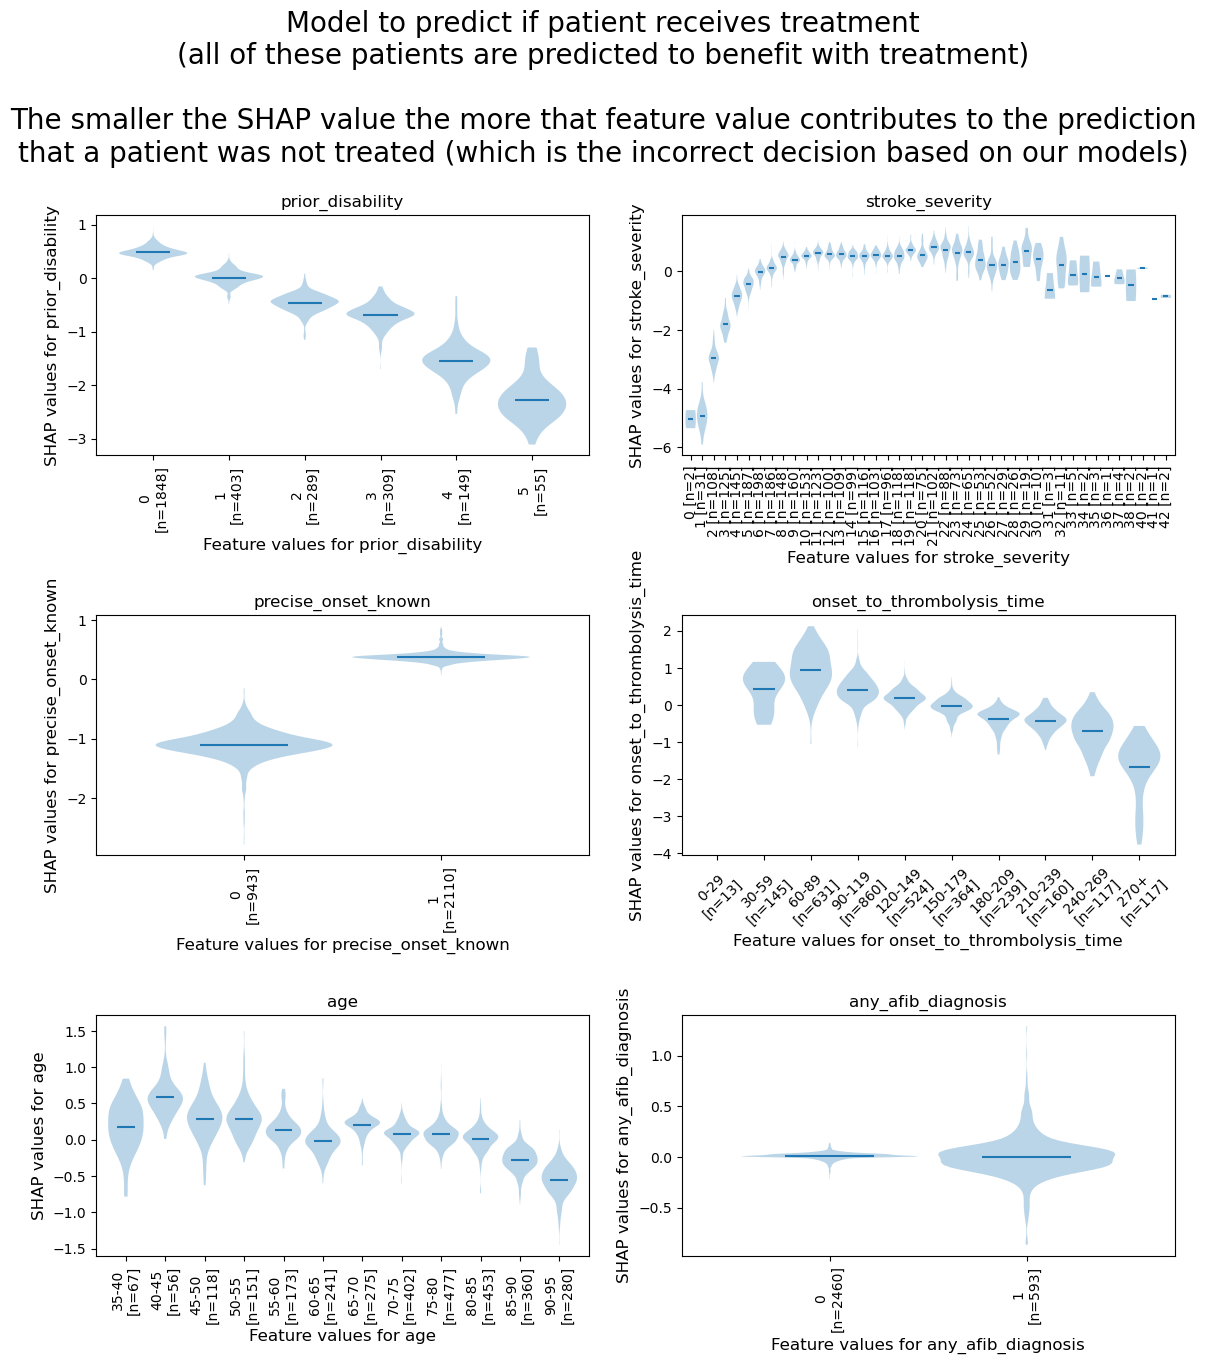

()

In [ ]:
# Features to include in the violin plot grid
features_violin = ["prior_disability", "stroke_severity", "precise_onset_known",
                "onset_to_thrombolysis_time", "age", "any_afib_diagnosis"]
filename = os.path.join(paths.image_save_path, (paths.notebook + 
                        paths.model_text + 
                        f'_shap_violin_all_features_all_benefit_with_ivt.jpg'))

title = ("Model to predict if patient receives treatment\n(all of these "
         "patients are predicted to benefit with treatment)\n\nThe smaller the "
         "SHAP value the more that feature value contributes to the "
         "prediction\nthat a patient was not treated (which is the incorrect "
         "decision based on our models)")

create_grid_of_violin_plots(features_violin, 
                            shap_values_extended_should,
                            title,
                            filename,
                            show_zero_shap=False)

Compare SHAP values for the hospital one-hot encoded features
The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (using only the first k-fold test set, and take the mean of the SHAP values for the instances for each hospital's own patients).

In [ ]:
def create_stroke_team_mean_shap_for_histogram(stroke_team_per_patient, 
                                               shap_values, input_features_ohe, 
                                               X_test):

    # Set up list for storing patient data and hospital SHAP
    feature_data_with_shap = []

    # Get mean SHAP for stroke team when patient attending that stroke team
    stroke_teams = list(np.unique(stroke_team_per_patient))
    stroke_teams.sort()
    stroke_team_mean_shap = []
    # Loop through stroke teams

    for stroke_team in stroke_teams:
        # Identify rows in test data that match each stroke team
        mask = np.array(stroke_team_per_patient) == stroke_team
        stroke_team_shap_all_features = shap_values[mask]
        # Get column index for stroke_team_in_shap
        feature_name = 'team_' + stroke_team
        index = input_features_ohe.index(feature_name)
        # Get SHAP values for hospital
        stroke_team_shap = stroke_team_shap_all_features[:, index]
        # Get mean
        mean_shap = np.mean(stroke_team_shap)
        # Store mean
        stroke_team_mean_shap.append(mean_shap)
        # Get and store feature data and add SHAP
        feature_data = X_test[mask]
        feature_data['Hospital_SHAP'] = stroke_team_shap
        feature_data_with_shap.append(feature_data)

    # Concatenate and save feature_data_with_shap
    feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)

    filename = os.path.join(paths.image_save_path, 
                            (paths.notebook + paths.model_text + 
                            '_feature_data_with_hospital_shap.jpg'))

    feature_data_with_shap.to_csv(filename, index=False)

    # Create and save shap mean value per hospital
    hospital_data = pd.DataFrame()
    hospital_data["stroke_team"] = stroke_teams
    hospital_data["shap_mean"] = stroke_team_mean_shap

    filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                            '_mean_shap_per_hospital.csv'))

    hospital_data.to_csv(filename, index=False)

    return(hospital_data)

Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients (using only the first k-fold test set)

In [ ]:
df_stroke_team_mean_shap_should = create_stroke_team_mean_shap_for_histogram(stroke_team_test_should, shap_values_should, input_features_ohe, X_test_should)

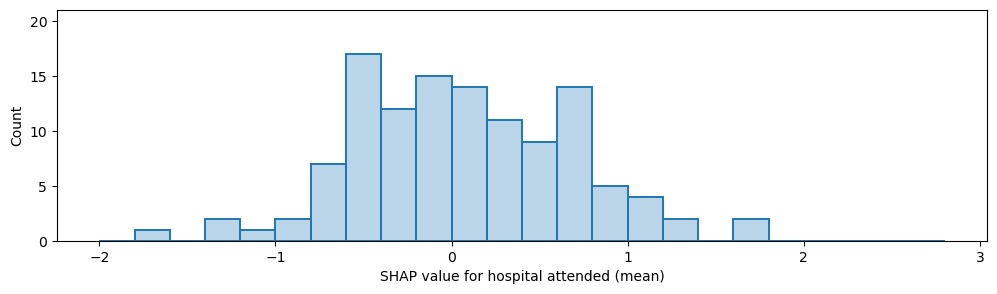

In [ ]:
# Plot histogram
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()
ax.hist(df_stroke_team_mean_shap_should["shap_mean"], bins=np.arange(-2, 3, 0.2), 
            color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
            ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
            linewidth=1.4)#stroke_team_mean_shap_should)#, bins=np.arange(-1.5, 1.51, 0.1))
ax.set_xlabel('SHAP value for hospital attended (mean)')
ax.set_ylabel('Count')
ax.set_ylim((0,21))
y_vals = range(0, 21, 5)
ax.set_yticks(y_vals)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_hosp_shap_hist_should.jpg'))
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Fit model to predict if get treatment, of those that should not.

Of the patients that should get treated predict whether get treated.

0 = Treated, incorrect decision
1 = Not treated, correct decision

In [ ]:
# Create mask to extract the population sample: should not treat
mask_should_not_treat = np.invert(mask_should_treat)

# Get the X data
X_should_not = copy.deepcopy(X)
X_should_not["onset_to_thrombolysis_time"] = test_and_mt_all_treated_onset_to_thrombolysis_time#["onset_to_thrombolysis_time"].values
X_should_not = X_should_not[mask_should_not_treat]

# Get the y data
y_should_not = df_treatment_decision_per_scenario[s2_name][mask_should_not_treat].values
# Reverse the target to represent "0" = should not treat, and do (incorrect), "1" = should not treat and are not (correct)
y_should_not = switch_0_and_1(y_should_not)

In [ ]:
mask_should_not_treat.sum()

6248

In [ ]:
# Set up or load test and train data
filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + 'dictionary_train_test_should_not.p'))

(X_train_should_not, X_test_should_not, y_train_should_not, y_test_should_not) = (
                        create_train_test_split(filename, X_should_not, y_should_not, test_size=0.25))

Stroke team attended for patients in the X_test_should_not (converting from one hot encoded to list of hospitals)

In [ ]:
team_col_names_should_not = [col for col in list(X_test_should_not) if "team_" in col]
stroke_team_test_should_not = X_test_should_not[team_col_names_should_not].idxmax(axis=1)
stroke_team_test_should_not = [s.replace('team_', '') for s in stroke_team_test_should_not]

In [ ]:
# Set up and fit model
filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + '_should_not.p'))
model_xgb_should_not = create_xgboost_model(filename, X_train_should_not, y_train_should_not)

# Predict training and test set labels
y_pred_train_xgb_should_not = model_xgb_should_not.predict(X_train_should_not)
y_pred_test_xgb_should_not = model_xgb_should_not.predict(X_test_should_not)

# Calculate accuracy of training and test sets
accuracy_train_should_not = np.mean(y_pred_train_xgb_should_not == y_train_should_not)
accuracy_test_should_not = np.mean(y_pred_test_xgb_should_not == y_test_should_not)

print ('Accuracy of predicting training data =', accuracy_train_should_not)
print ('Accuracy of predicting test data =', accuracy_test_should_not)

Accuracy of predicting training data = 0.9239938080495356
Accuracy of predicting test data = 0.8319405756731661


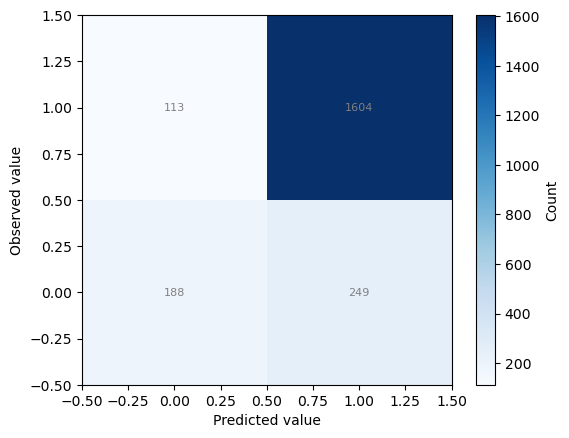

()

In [ ]:
plot_cm(confusion_matrix(y_test_should_not, y_pred_test_xgb_should_not))

In [ ]:
# Show first ten predicted probabilities 
# (note how the values relate to the classes predicted above)
probabilities_xgb_should_not = model_xgb_should_not.predict_proba(X_test_should_not)


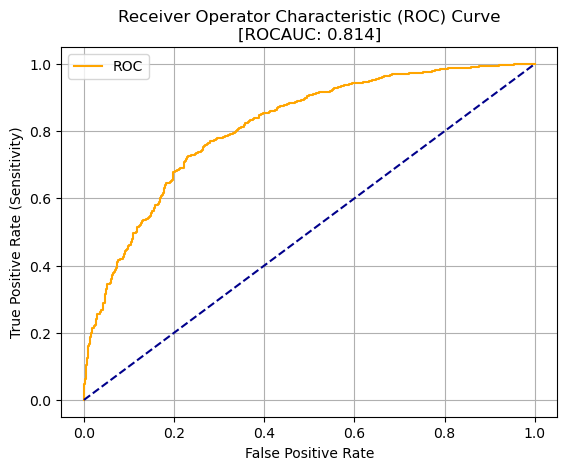

()

In [ ]:
# Get ROC curve using sklearn method
fpr, tpr, thresholds = roc_curve(y_test_should_not, probabilities_xgb_should_not[:,1]) 

# Plot ROC curve
plot_roc_curve(fpr, tpr)

In [ ]:
# Set filename
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                            f'_shap_values_extended_should_not_{s1_name}_{s2_name}.p'))

explainer_filename = os.path.join(paths.data_save_path, 
                    (paths.notebook + paths.model_text + 
                        f'_shap_explainer_should_not_{s1_name}_{s2_name}.p'))

# Get and store SHAP values
shap_values_extended_should_not = calculate_shap_extended(model_xgb_should_not, X_train_should_not, X_test_should_not, filename, explainer_filename)
shap_values_should_not = shap_values_extended_should_not.values

In [ ]:
# Get and store feature importances
shap_feature_importance_should_not_df = pd.DataFrame() # create empty DataFrame
shap_feature_importance_should_not_df['feature'] = list(X) # Get feature names from X
shap_feature_importance_should_not_df['importance'] = model_xgb_should_not.feature_importances_
shap_feature_importance_should_not_df['abs(mean shap)'] = abs(shap_values_should_not.mean(axis=0))
shap_feature_importance_should_not_df['mean(abs shap)'] = abs(shap_values_should_not).mean(axis=0)
shap_feature_importance_should_not_df.sort_values(by='mean(abs shap)', ascending=False, inplace=True)

shap_feature_importance_should_not_df.head(20)

,feature,importance,abs(mean shap),mean(abs shap)
1,stroke_severity,0.019783,0.118460,0.996927
5,precise_onset_known,0.035997,0.002985,0.593317
3,onset_to_thrombolysis_time,0.008492,0.027594,0.526892
4,any_afib_diagnosis,0.049901,0.012087,0.505181
0,prior_disability,0.013398,0.113780,0.443382
2,age,0.009517,0.090685,0.276976
11,team_6,0.015006,0.030686,0.063032
6,team_1,0.011711,0.007424,0.061905
114,team_109,0.011714,0.004122,0.043318
56,team_51,0.010583,0.016738,0.033231


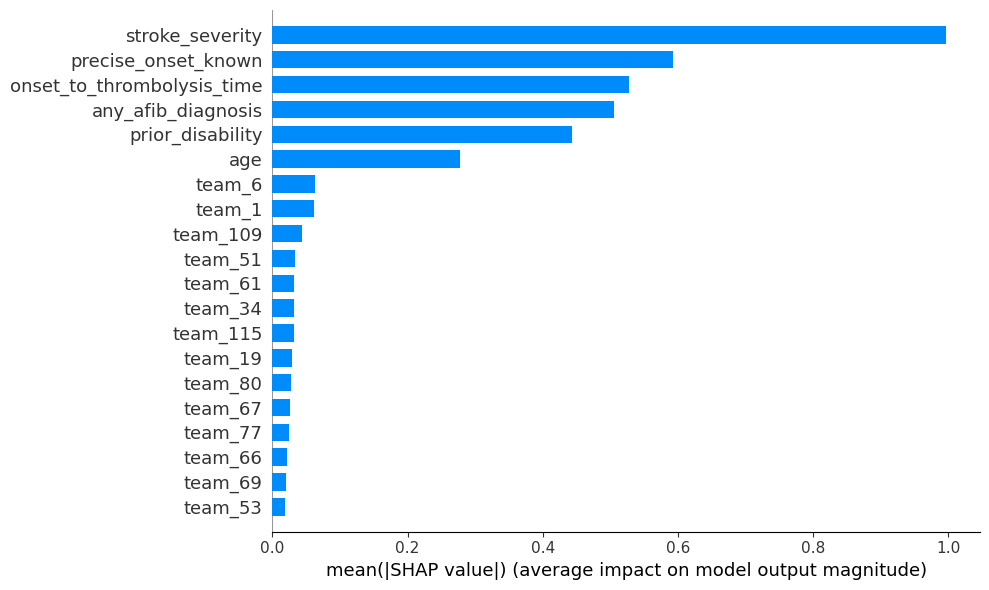

In [ ]:
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_should_not, X_test_should_not.values, plot_type="bar", 
                  class_names=model_xgb_should_not.classes_, 
                  feature_names = list(X), class_inds="original",
                  show=False, plot_size=(10,6))

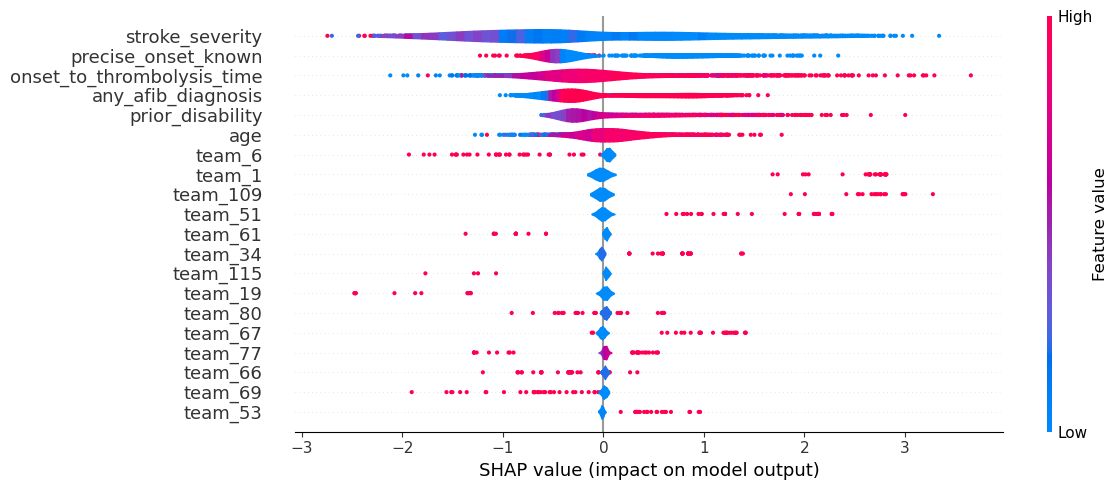

In [ ]:
shap.summary_plot(shap_values_should_not, X_test_should_not.values, 
                  feature_names=X_test_should_not.columns, show=False, 
                    plot_size=(12,5), plot_type='violin')

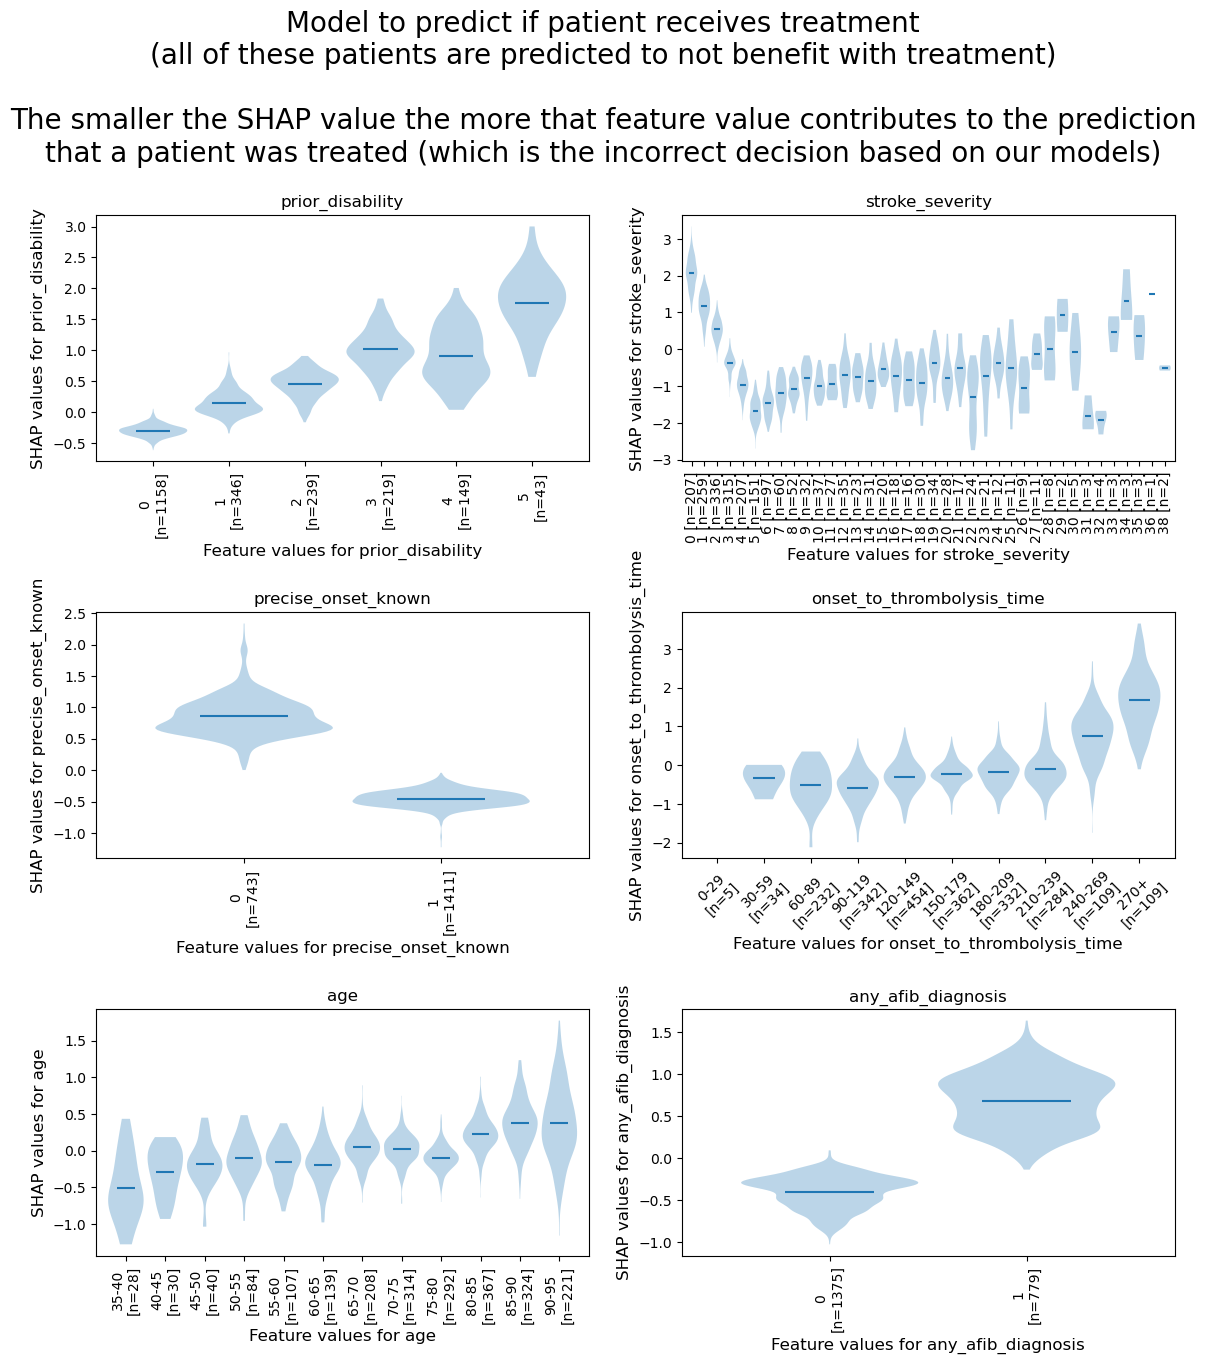

()

In [ ]:
# Features to include in the violin plot grid
features_violin = ["prior_disability", "stroke_severity", "precise_onset_known",
                "onset_to_thrombolysis_time", "age", "any_afib_diagnosis"]

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                        paths.model_text + 
                        f'_shap_violin_all_features_none_benefit_with_ivt.jpg'))

title = ("Model to predict if patient receives treatment\n(all of these "
         "patients are predicted to not benefit with treatment)\n\nThe smaller "
         "the SHAP value the more that feature value contributes to the "
         "prediction\nthat a patient was treated (which is the incorrect "
         "decision based on our models)")

create_grid_of_violin_plots(features_violin, 
                            shap_values_extended_should_not,
                            title,
                            filename,
                            show_zero_shap=False)

Create histogram for hospital attended shap

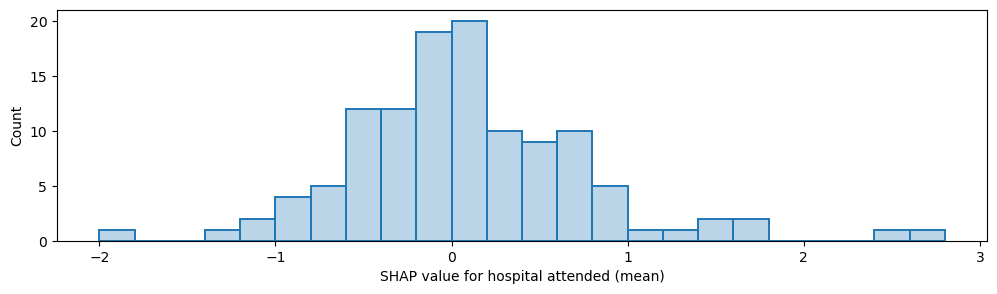

In [ ]:
df_stroke_team_mean_shap_should_not = create_stroke_team_mean_shap_for_histogram(stroke_team_test_should_not, shap_values_should_not, input_features_ohe, X_test_should_not)
# Plot histogram
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()
ax.hist(df_stroke_team_mean_shap_should_not["shap_mean"], bins=np.arange(-2, 3, 0.2), 
            color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
            ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
            linewidth=1.4)#stroke_team_mean_shap_should)#, bins=np.arange(-1.5, 1.51, 0.1))
ax.set_xlabel('SHAP value for hospital attended (mean)')
ax.set_ylabel('Count')
ax.set_ylim((0,21))
y_vals = range(0, 21, 5)
ax.set_yticks(y_vals)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_hosp_shap_hist_should not.jpg'))
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
def identify_pareto_front(scores_for_pareto, utopia="top_right"):
    """
    Identified parteto front for numpy array of scores.
    For any scores where 'lower is better' invesre of score should be used
    """
    population_size = scores_for_pareto.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)

    if utopia == "top_right":
        for i in range(population_size):
            for j in range(population_size):
                if all(scores_for_pareto[j] >= scores_for_pareto[i]) and any(
                        scores_for_pareto[j] > scores_for_pareto[i]):
                    # j dominates i
                    pareto_front[i] = 0
                    break
    elif utopia == "bottom_left":
        for i in range(population_size):
            for j in range(population_size):
                if all(scores_for_pareto[j] <= scores_for_pareto[i]) and any(
                        scores_for_pareto[j] < scores_for_pareto[i]):
                    # j dominates i
                    pareto_front[i] = 0
                    break
    else:
        print("Check utopia value")

    return (pareto_front)

In [ ]:
df_stroke_team_mean_shap = df_stroke_team_mean_shap_should_not.copy(deep=True)
df_stroke_team_mean_shap.set_index("stroke_team", inplace=True)
df_stroke_team_mean_shap = df_stroke_team_mean_shap.join(df_stroke_team_mean_shap_should.set_index("stroke_team"), rsuffix="_")
df_stroke_team_mean_shap.columns=["shap_mean_should_not", "shap_mean_should"]

Plot using specificity and sensitivity

In [ ]:
def plot_sensitivity_specificity_not_used(shap_values_good_treated, 
                                 proportion_good_treated, 
                                 shap_values_bad_not, 
                                 proportion_bad_not,
                                 hospital_names = df_stroke_team_mean_shap.index):

    # Calc sensitivity

    # Odds = P/ (1-P)
    odds = proportion_good_treated / (1-proportion_good_treated)

    # Take log odds
    log_odds = np.log(odds)

    # Add shap
    adjusted_log_odds = log_odds + shap_values_good_treated

    # Reverse log
    adjusted_odds = np.exp(adjusted_log_odds)

    # Convert back to proportion (P = O / (1+O)
    sensitivity = adjusted_odds / (1 + adjusted_odds)

    # Calc specificity

    # Odds = P/ (1-P)
    odds = proportion_bad_not / (1-proportion_bad_not)
    # Take log odds
    log_odds = np.log(odds)

    # Add shap
    adjusted_log_odds = log_odds + shap_values_bad_not

    # Reverse log
    adjusted_odds = np.exp(adjusted_log_odds)

    # Convert back to proportion (P = O / (1+O)
    specificity = adjusted_odds / (1 + adjusted_odds)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    ax.scatter(sensitivity, specificity, s=10, c="k")
    ax.set_xlabel('Sensitivity of treatment\n(proportion of patients who would benefit\nfrom treatment who are treated)')
    ax.set_ylabel('Specificity of treatment\n(proportion of patients who would not benefit\nfrom treatment who are not treated)')


    # label some points to check position
    for i, txt in enumerate(hospital_names[:10]):
        plt.annotate(txt, (sensitivity[i], specificity[i]))#

    plt.show()

In [ ]:
def calc_sensitivity(shap_values_good_treated, 
                     proportion_good_treated):

    # Calc sensitivity

    # Odds = P/ (1-P)
    odds = proportion_good_treated / (1-proportion_good_treated)

    # Take log odds
    log_odds = np.log(odds)

    # Add shap
    adjusted_log_odds = log_odds + shap_values_good_treated

    # Reverse log
    adjusted_odds = np.exp(adjusted_log_odds)

    # Convert back to proportion (P = O / (1+O)
    sensitivity = adjusted_odds / (1 + adjusted_odds)

    return(sensitivity)

In [ ]:
def calc_specificity(shap_values_bad_not, 
                     proportion_bad_not):

    # Calc specificity

    # Odds = P/ (1-P)
    odds = proportion_bad_not / (1-proportion_bad_not)
    # Take log odds
    log_odds = np.log(odds)

    # Add shap
    adjusted_log_odds = log_odds + shap_values_bad_not

    # Reverse log
    adjusted_odds = np.exp(adjusted_log_odds)

    # Convert back to proportion (P = O / (1+O)
    specificity = adjusted_odds / (1 + adjusted_odds)

    return(specificity)

In [ ]:
def plot_sensitivity_specificity(df, names=False):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    ax.scatter(df["sensitivity"], df["specificity"], s=10, c="k")
    ax.set_xlabel('Sensitivity of treatment\n(proportion of patients who would benefit\nfrom treatment who are treated)')
    ax.set_ylabel('Specificity of treatment\n(proportion of patients who would not benefit\nfrom treatment who are not treated)')

    if names:
        # label some points to check position
        for i, txt in enumerate(df.index[:10]):
            plt.annotate(txt, (df["sensitivity"][i], df["specificity"][i]))


    # plot pareto
    pareto_front = identify_pareto_front(df.values, utopia="top_right")
    df_hosp_shap_pareto_front = df[pareto_front]
    plt.scatter(df_hosp_shap_pareto_front["sensitivity"],df_hosp_shap_pareto_front["specificity"], s=10, c="blue")

    # line between points
    df_hosp_shap_pareto_front = df_hosp_shap_pareto_front.sort_values("sensitivity")
    for i in range(df_hosp_shap_pareto_front.shape[0]-1):
        plt.plot(df_hosp_shap_pareto_front.values[i:i+2,0], df_hosp_shap_pareto_front.values[i:i+2, 1], c="blue")

    plt.xlim(0.2,1)
    plt.ylim(0.2,1)
    plt.show()
    return()

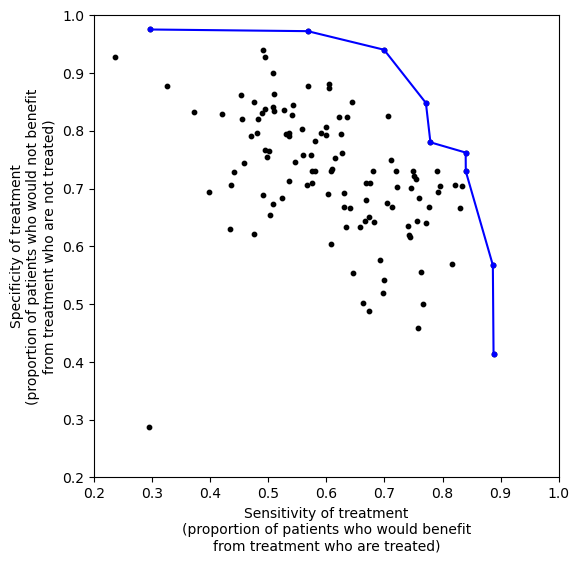

()

In [ ]:
venn_diagram_columns = ["Actual_treatment", "Lowest_weighted_mrs_and_least_mrs5_6"]

# proportion of patients that should be treated, are treated
mask = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==1
denominator = mask.sum()
n_patients_are_should = (df_treatment_decision_per_scenario["Actual_treatment"][mask]==1).sum()
proportion_treated_are_good = n_patients_are_should/denominator

# proportion of patients that should not be treated, are not treated
mask = df_treatment_decision_per_scenario["Lowest_weighted_mrs_and_least_mrs5_6"]==0
denominator = mask.sum()
n_patients_not_shouldnt = (df_treatment_decision_per_scenario["Actual_treatment"][mask]==0).sum()
proportion_not_treated_are_bad = n_patients_not_shouldnt/denominator

df_stroke_team_sens_spec = pd.DataFrame()

df_stroke_team_sens_spec["sensitivity"] = calc_sensitivity(
                    df_stroke_team_mean_shap["shap_mean_should"].values,
                    proportion_treated_are_good)

df_stroke_team_sens_spec["specificity"] = calc_specificity(
                    df_stroke_team_mean_shap["shap_mean_should_not"].values,
                    proportion_not_treated_are_bad)

df_stroke_team_sens_spec.set_index(df_stroke_team_mean_shap.index, inplace=True)

plot_sensitivity_specificity(df_stroke_team_sens_spec, names=False)

### Save file to be used in notebook 220 to train a XGBoost regression model to predict the predicted shift in mRS due to treatment.

That model will use the same input features as those used in the disability discharge outcome model. We will then fit SHAP values to the mRS shift model.

In [ ]:
data["predicted_mrs_shift_due_to_thrombolysis"] = (
                                    predicted_mrs_shift_due_to_thrombolysis)

filename = os.path.join(paths.data_save_path,
                (paths.notebook + paths.model_text + '_predicted_mrs_shift_due_to_thrombolysis.csv'))
data.to_csv(filename)

***